###  Benchmarking based on CPTACS06 datasets

#### The CPTAC Study 6 datasets includes 48 UPS1 proteins-spiked into a yeast proteome digest in five different concentrations: 0.25, 0.74, 2.2, 6.7 and 20 fmol/ul. An LTQ Orbitrap MS was used to analyze three technical replicates of each concentration (at test site 86). See original details in DOI: 10.1021/pr9006365. 
#### A fasta database of the yeast protein sequences merged with the UPS1 proteins sequence use used for searching. A false discoving rate of 0.01 was set as a threshold for peptide identifications and protein-level identifications

In [1]:
%load_ext rpy2.ipython

C:\Users\ChengXin\MyProgram\python\anaconda\pro\lib\site-packages\rpy2\robjects\packages.py:367: UserWarning: The symbol 'quartz' is not in this R namespace/package.
  "The symbol '%s' is not in this R namespace/package." % name


In [2]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns

In [3]:
%%R
data_folder = '../datasets/CPTACS06'
setwd(data_folder)

### The total number of proteins quantified is 1477 by quantms, which quantified more proteins than other researches. such as DOI: 10.1093/bib/bbx054

In [4]:
quantms = pd.read_csv("./out_msstats.csv", sep=',', header=0)
quantms = quantms[-quantms['ProteinName'].str.contains("DECOY_")]
print(len(set(quantms['ProteinName'])))
quantms.head()


1477


,ProteinName,PeptideSequence,PrecursorCharge,FragmentIon,ProductCharge,IsotopeLabelType,Condition,BioReplicate,Run,Intensity,Reference
0,sp|P38915|SPT8_YEAST,AAAAGAGGAGDSGDAVTK,2,NaN,0,L,CT=Mixture;CN=UPS1;QY=0.25 fmol,1,2,453741.0,20080313_CPTAC6_07_6A005.mzML
1,sp|P0C0T4|RS25B_YEAST;sp|Q3E792|RS25A_YEAST,AAAALAGGKK,2,NaN,0,L,CT=Mixture;CN=UPS1;QY=6.67 fmol,4,11,1790237.0,20080313_CPTAC6_16_6D014.mzML
2,sp|P0C0T4|RS25B_YEAST;sp|Q3E792|RS25A_YEAST,AAAALAGGKK,2,NaN,0,L,CT=Mixture;CN=UPS1;QY=6.67 fmol,4,12,6418917.0,20080315_CPTAC6_16_6D014.mzML
3,sp|P0C0T4|RS25B_YEAST;sp|Q3E792|RS25A_YEAST,AAAALAGGKK,2,NaN,0,L,CT=Mixture;CN=UPS1;QY=20.00 fmol,5,14,4136037.0,20080313_CPTAC6_19_6E010.mzML
4,sp|P0C0T4|RS25B_YEAST;sp|Q3E792|RS25A_YEAST,AAAALAGGKK,2,NaN,0,L,CT=Mixture;CN=UPS1;QY=20.00 fmol,5,15,4285083.0,20080315_CPTAC6_19_6E010.mzML


### The total number of spiked-in proteins detected is 43（48）,which is better than original results. As the protein concentration decreases, the number of proteins detected is less. 

43


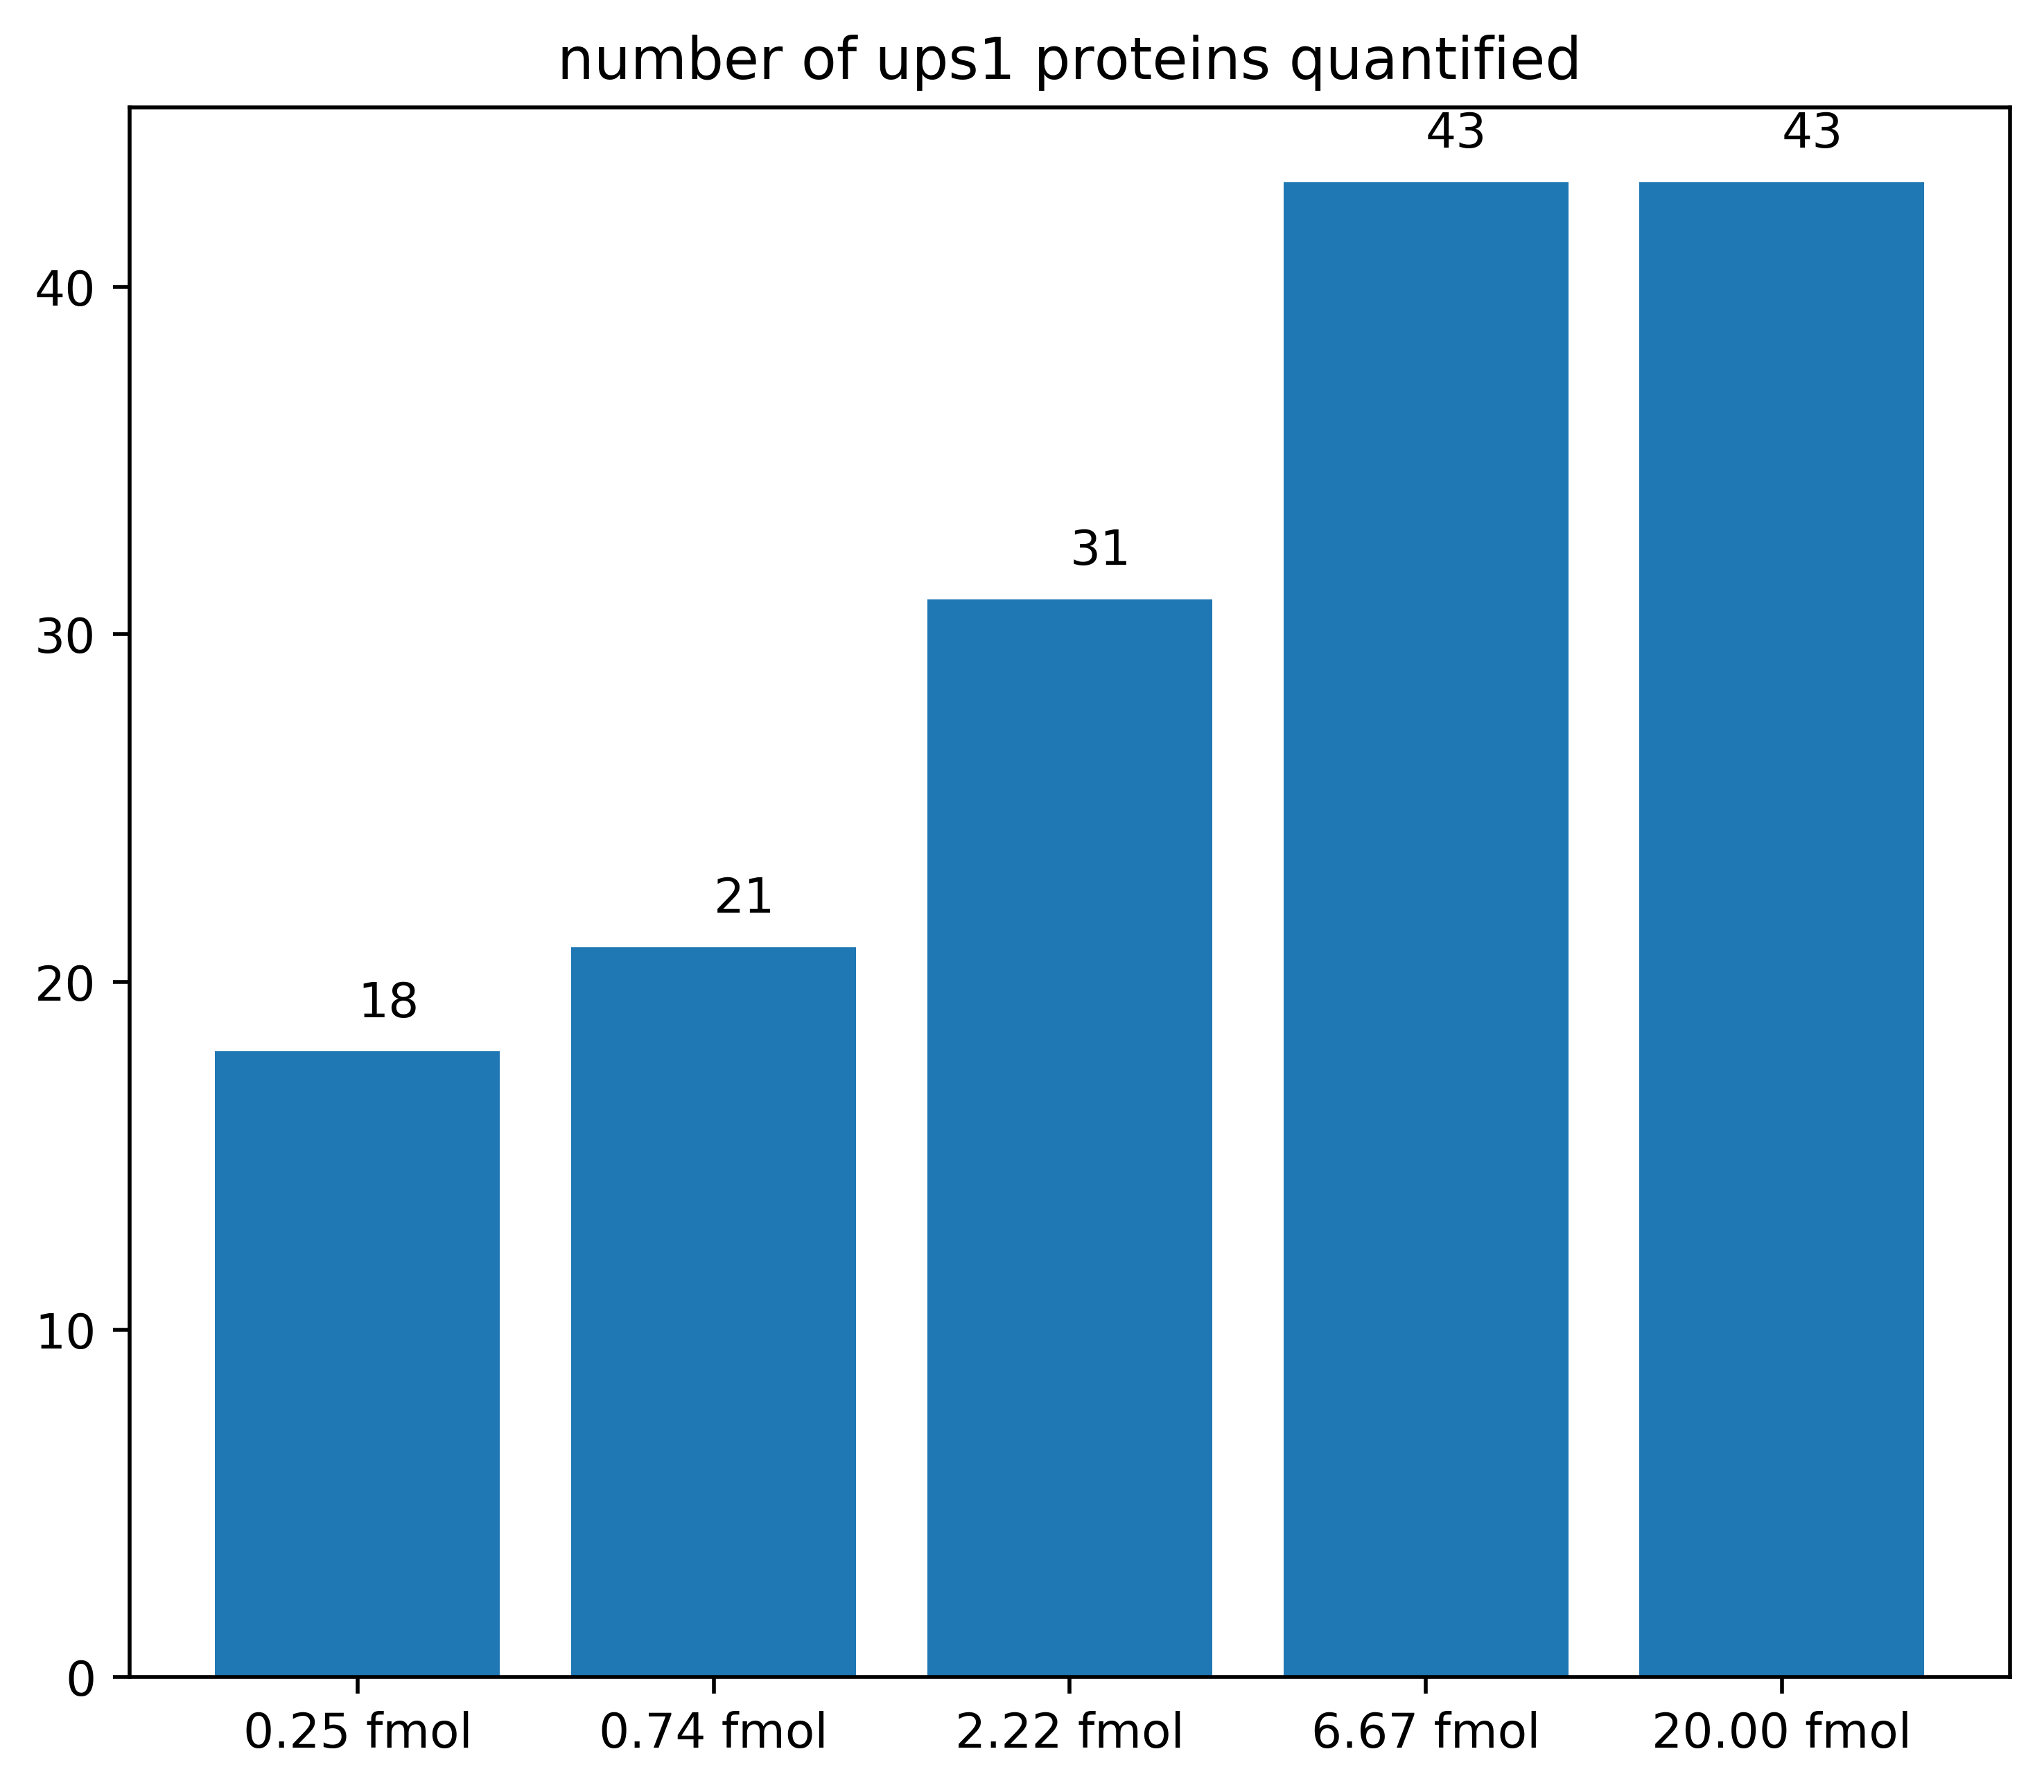

In [5]:
number_of_ups1 = dict()
print(len(set(quantms[quantms['ProteinName'].str.contains("UPS")]['ProteinName'])))
for condition in np.unique(quantms['Condition']):
    number_of_ups1[condition.replace("CT=Mixture;CN=UPS1;QY=", "")] = len((set(quantms.loc[(quantms['ProteinName'].str.contains("UPS")) & (quantms['Condition'] == condition), 'ProteinName'])))

plt.figure(figsize=(7,6), dpi=500)
num = []
label = []
for key, value in sorted(number_of_ups1.items(), key=lambda item: float(item[0].replace("fmol",""))):
    num.append(value)
    label.append(key)
for x, y in zip(range(5), num):
    plt.text(x, y+1, y)

plt.bar(range(5), num)
plt.title("number of ups1 proteins quantified")
plt.xticks(range(5),label)
plt.show()

### Assess missing value

#### A common and pervasive problem in MS data are missing values. When using peptide peaking intensities for relative quantification, missing values are intensity values that are not recorded for a peptide in a sample/replicates. Missing values can occur because of multiple reasons and are mainly divided into two main categories : abundance-depdendent missing values (eg. the concentration of the peptide is below the detection limit of the instrument) or values missing completely at random (eg. the identification of the peptide is incorrect)

#### Proportion of missing values in the detected spiked-in proteins is 16.2% . better than original result: MaxQuant: 29.4%, OpenMS:23.6% et al.

In [6]:
missing_values_ups = 0
total = 0
for condition in np.unique(quantms['Condition']):
    quant_condition = quantms.loc[(quantms['ProteinName'].str.contains("UPS")) & (quantms['Condition'] == condition)]
    for protein in np.unique(quant_condition['ProteinName']):
        msruns = np.unique(quant_condition[quant_condition['ProteinName'] == protein]['Run'])
        total += 3
        if len(msruns) < 3:
            missing_values_ups += (3 - len(msruns))
            
print(missing_values_ups / total)

0.1623931623931624


#### Proportion of missing value in background proteins is 20.7%, which is basically same as other results. It is better than another openms workflow

In [7]:
missing_values_background = 0
total = 0
for condition in np.unique(quantms['Condition']):
    quant_condition = quantms.loc[(-quantms['ProteinName'].str.contains("UPS")) & (quantms['Condition'] == condition)]
    for protein in np.unique(quant_condition['ProteinName']):
        total += 3
        msruns = np.unique(quant_condition[quant_condition['ProteinName'] == protein]['Run'])
        if len(msruns) < 3:
            missing_values_background += (3 - len(msruns))
            
print(missing_values_background / total)

0.2077746412608798


### Reproducibility/Repeatability between Analytical Replicate before msstats process

#### Proteomics analysis has many possiable sources of variability, although these variations impacts the identification of peptides and for replicates, proteomic identifications are far from completely random. 

#### Testing each concentration in triplicate allowed us to calculate a coefficient of variation (CV) of peptide/protein intensities to asses signal extraction reproducibility annd workflow consistency, those are very important for proteomics analysis!

#### Calculate the metrics before msstats process to assess quantms. Of course is it necessary to calculate this metric after msstats processing?.  Ignoring missing proteins at the same time. Missing values will be considered seperately.

#### CV = protein mean  intensity within replicates / corresponding std. For the peptide intensity, abundances are summed over all charge states. Protein abundance will be computed from peptide abundances based on median. is it right ????.CV is calculated separately in background proteins and UPS1 proteins.

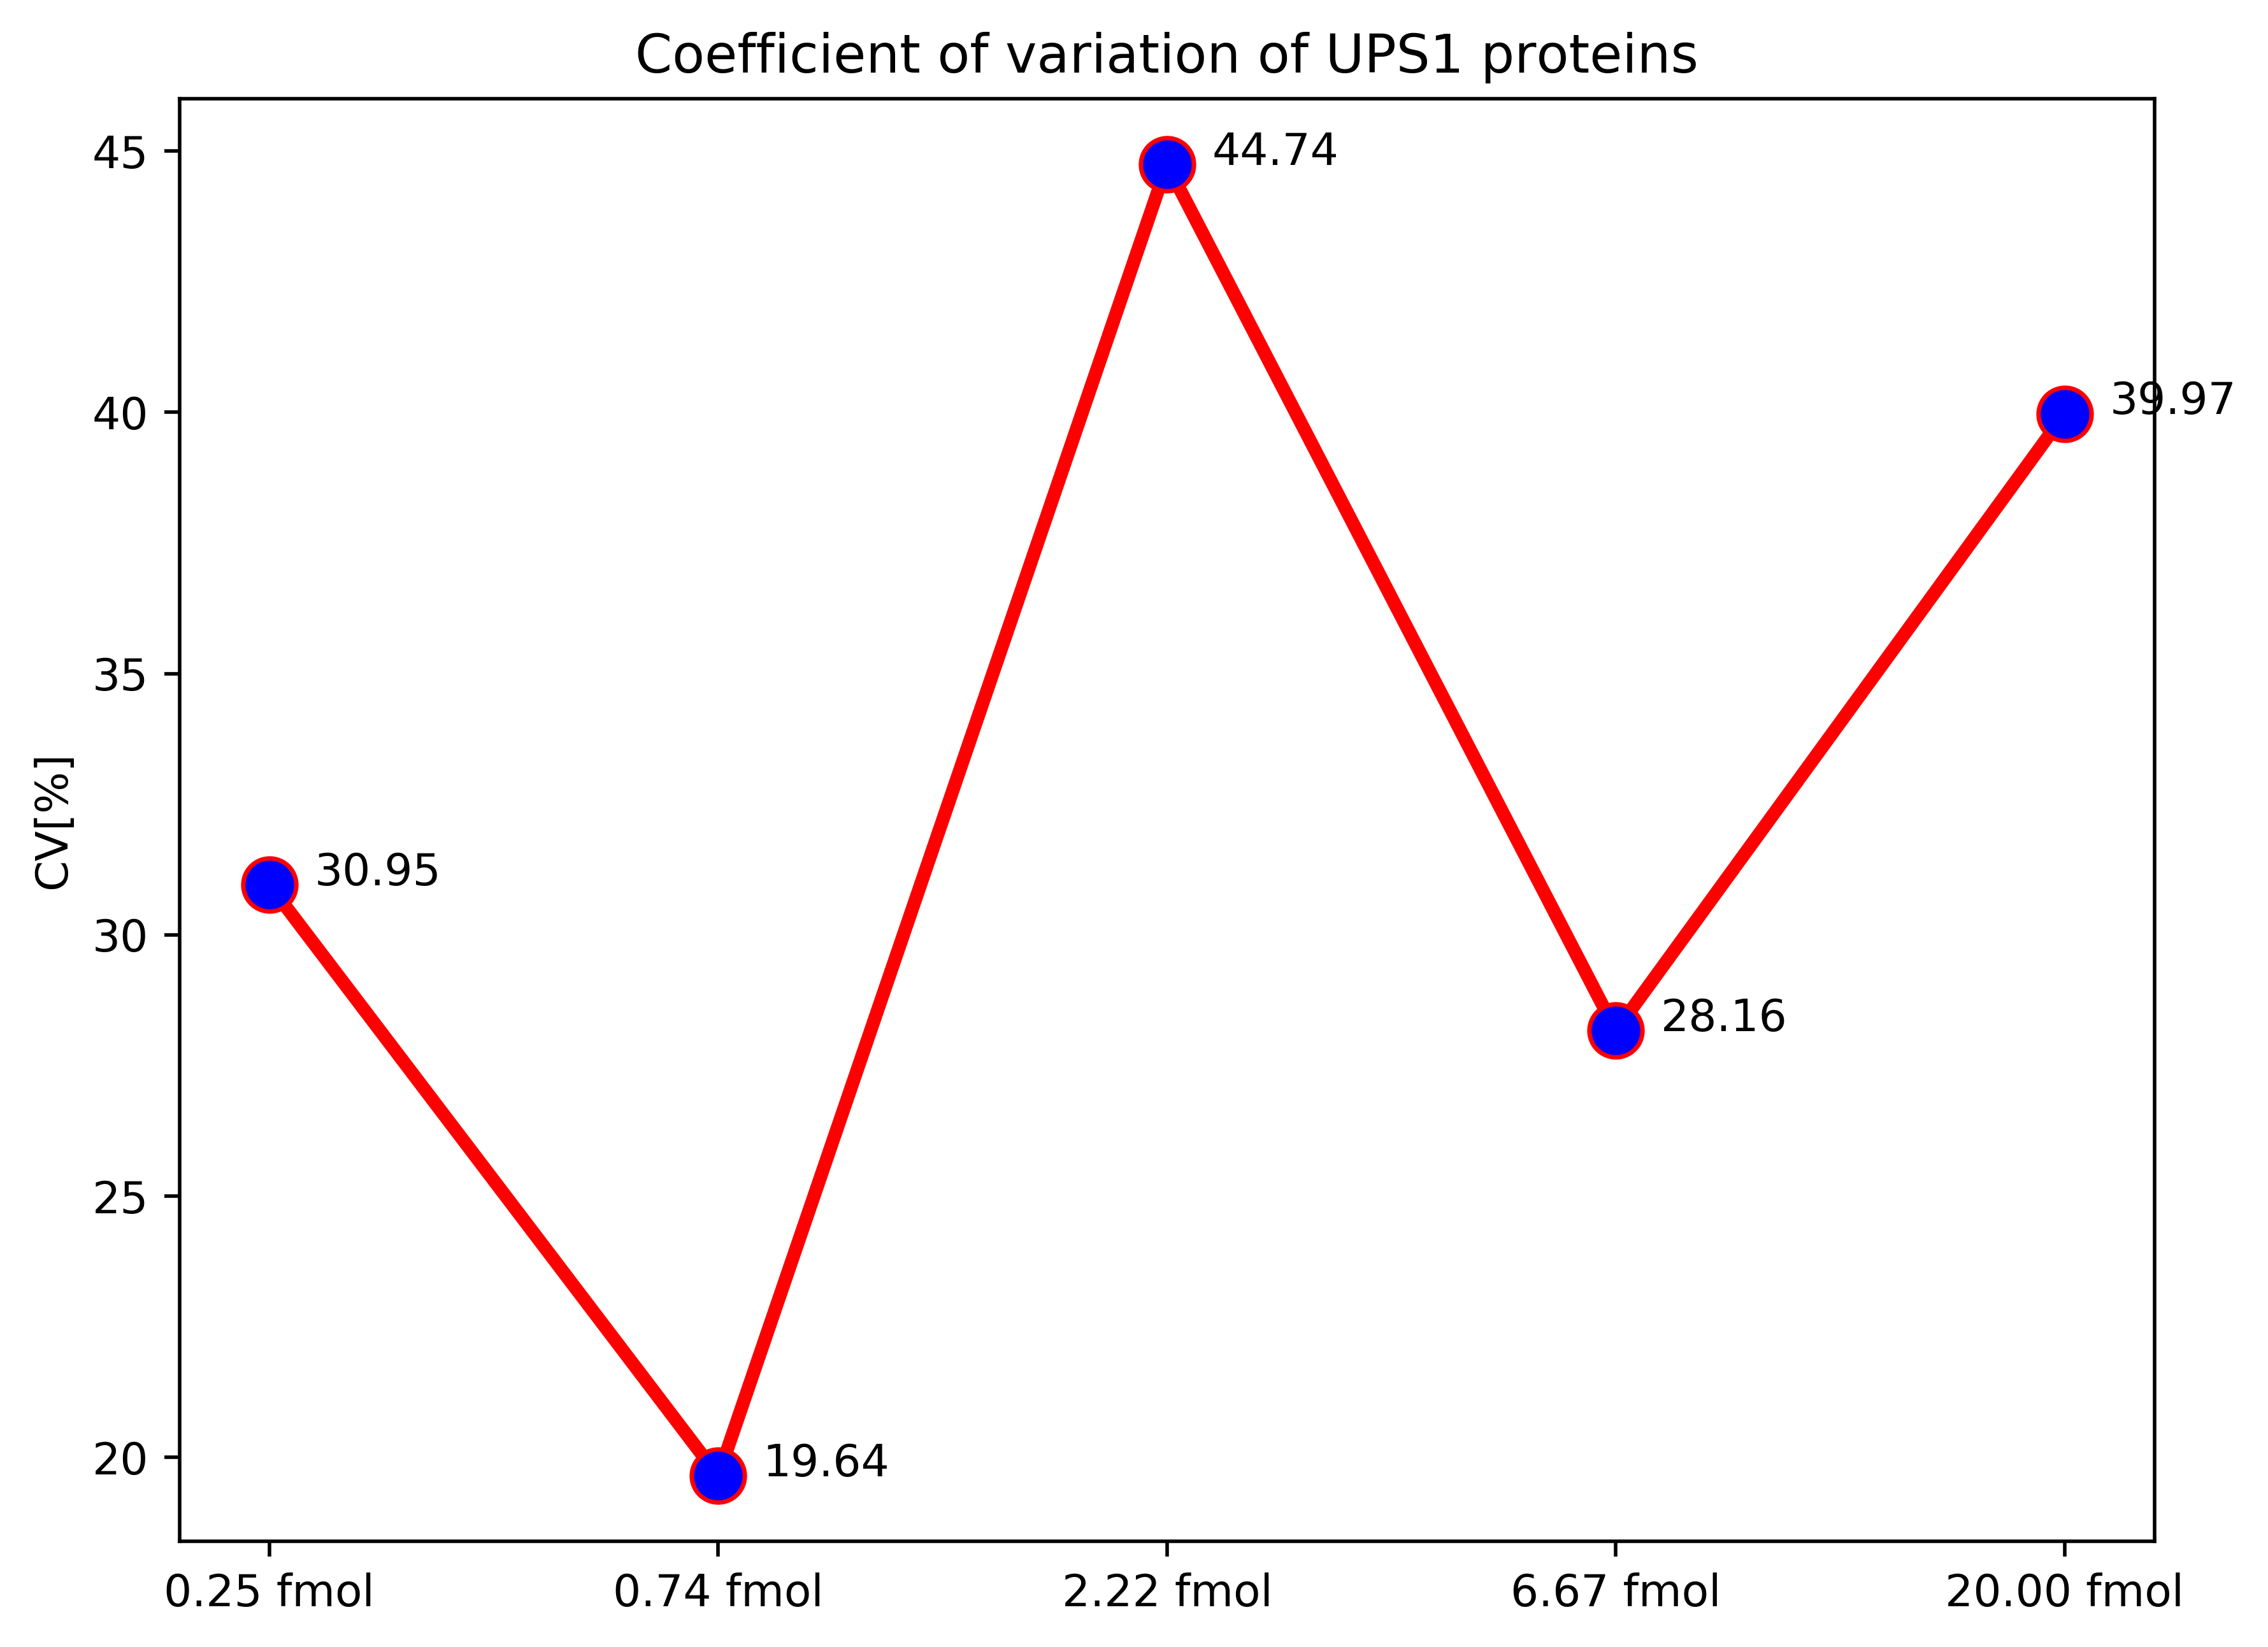

In [8]:
n_data = pd.DataFrame(None,columns = ['ProteinName','TechRep1','TechRep2', 'TechRep3', 'Condition', "CV[%]"])
for condition in np.unique(quantms['Condition']):
    if len(quantms.loc[(quantms['ProteinName'].str.contains("UPS")) & (quantms['Condition'] == condition)]) < 3:
        continue
    quant_condition = quantms.loc[(quantms['ProteinName'].str.contains("UPS")) & (quantms['Condition'] == condition)]
    for protein in np.unique(quant_condition['ProteinName']):
        msruns = np.unique(quant_condition[quant_condition['ProteinName'] == protein]['Run'])
        
        # proteins were filtered out if not quantified in all replicates
        if len(msruns) < 3:
            continue
            
        tech_intensity = []
        
        # summarized protein intensity in a technical replicate
        for run in msruns:
            t = quant_condition[(quant_condition['ProteinName'] == protein) & ((quant_condition['Run'] == run))]
            pep_intensity = []
            for pep in np.unique(t['PeptideSequence']):
                pep_intensity.append(np.sum(t[t['PeptideSequence'] == pep]['Intensity']))
                
            tech_intensity.append(np.median(pep_intensity))
        mean = np.mean(tech_intensity)
        std = np.std(tech_intensity)
        n_data = n_data.append({'ProteinName':protein,'TechRep1':tech_intensity[0], 
                       'TechRep2': tech_intensity[1], 'TechRep3': tech_intensity[2], 
                       'Condition': condition, "CV[%]": 100 * (std / mean)}, ignore_index=True)

# calcualte average CV in UPS1 proteins without missing value
cvs = []
xticks = []
plt.figure(figsize=(8,6), dpi=500)
conditions = np.unique(n_data["Condition"])
conditions = sorted(conditions, key= lambda x: float(x.replace("CT=Mixture;CN=UPS1;QY=","").replace("fmol", "")))
for condition in conditions:
    cvs.append(np.mean(n_data[n_data['Condition'] == condition]["CV[%]"]))
    xticks.append(condition.replace("CT=Mixture;CN=UPS1;QY=",""))
    
plt.plot(range(5), cvs, linewidth=3, color='r', marker='o',markerfacecolor='blue', markersize=12)
plt.xticks(range(5), xticks)
for i in range(5):
    plt.text(i+0.1, cvs[i], round(cvs[i], 2))
plt.ylabel('CV[%]')
plt.title('Coefficient of variation of UPS1 proteins')
plt.show()

#### Calcaulate CV of backgroud Proteins.

#### 0.25 fmol mean cv: 37.069892
#### 0.74 fmol mean cv: 30.561459
#### 2.22 fmol mean cv: 31.361179
#### 20.00 fmol mean cv: 32.668720
#### 6.67 fmol mean cv: 28.061015

CT=Mixture;CN=UPS1;QY=0.25 fmol mean cv: 37.069892
CT=Mixture;CN=UPS1;QY=0.74 fmol mean cv: 30.561459
CT=Mixture;CN=UPS1;QY=2.22 fmol mean cv: 31.361179
CT=Mixture;CN=UPS1;QY=20.00 fmol mean cv: 32.668720
CT=Mixture;CN=UPS1;QY=6.67 fmol mean cv: 28.061015


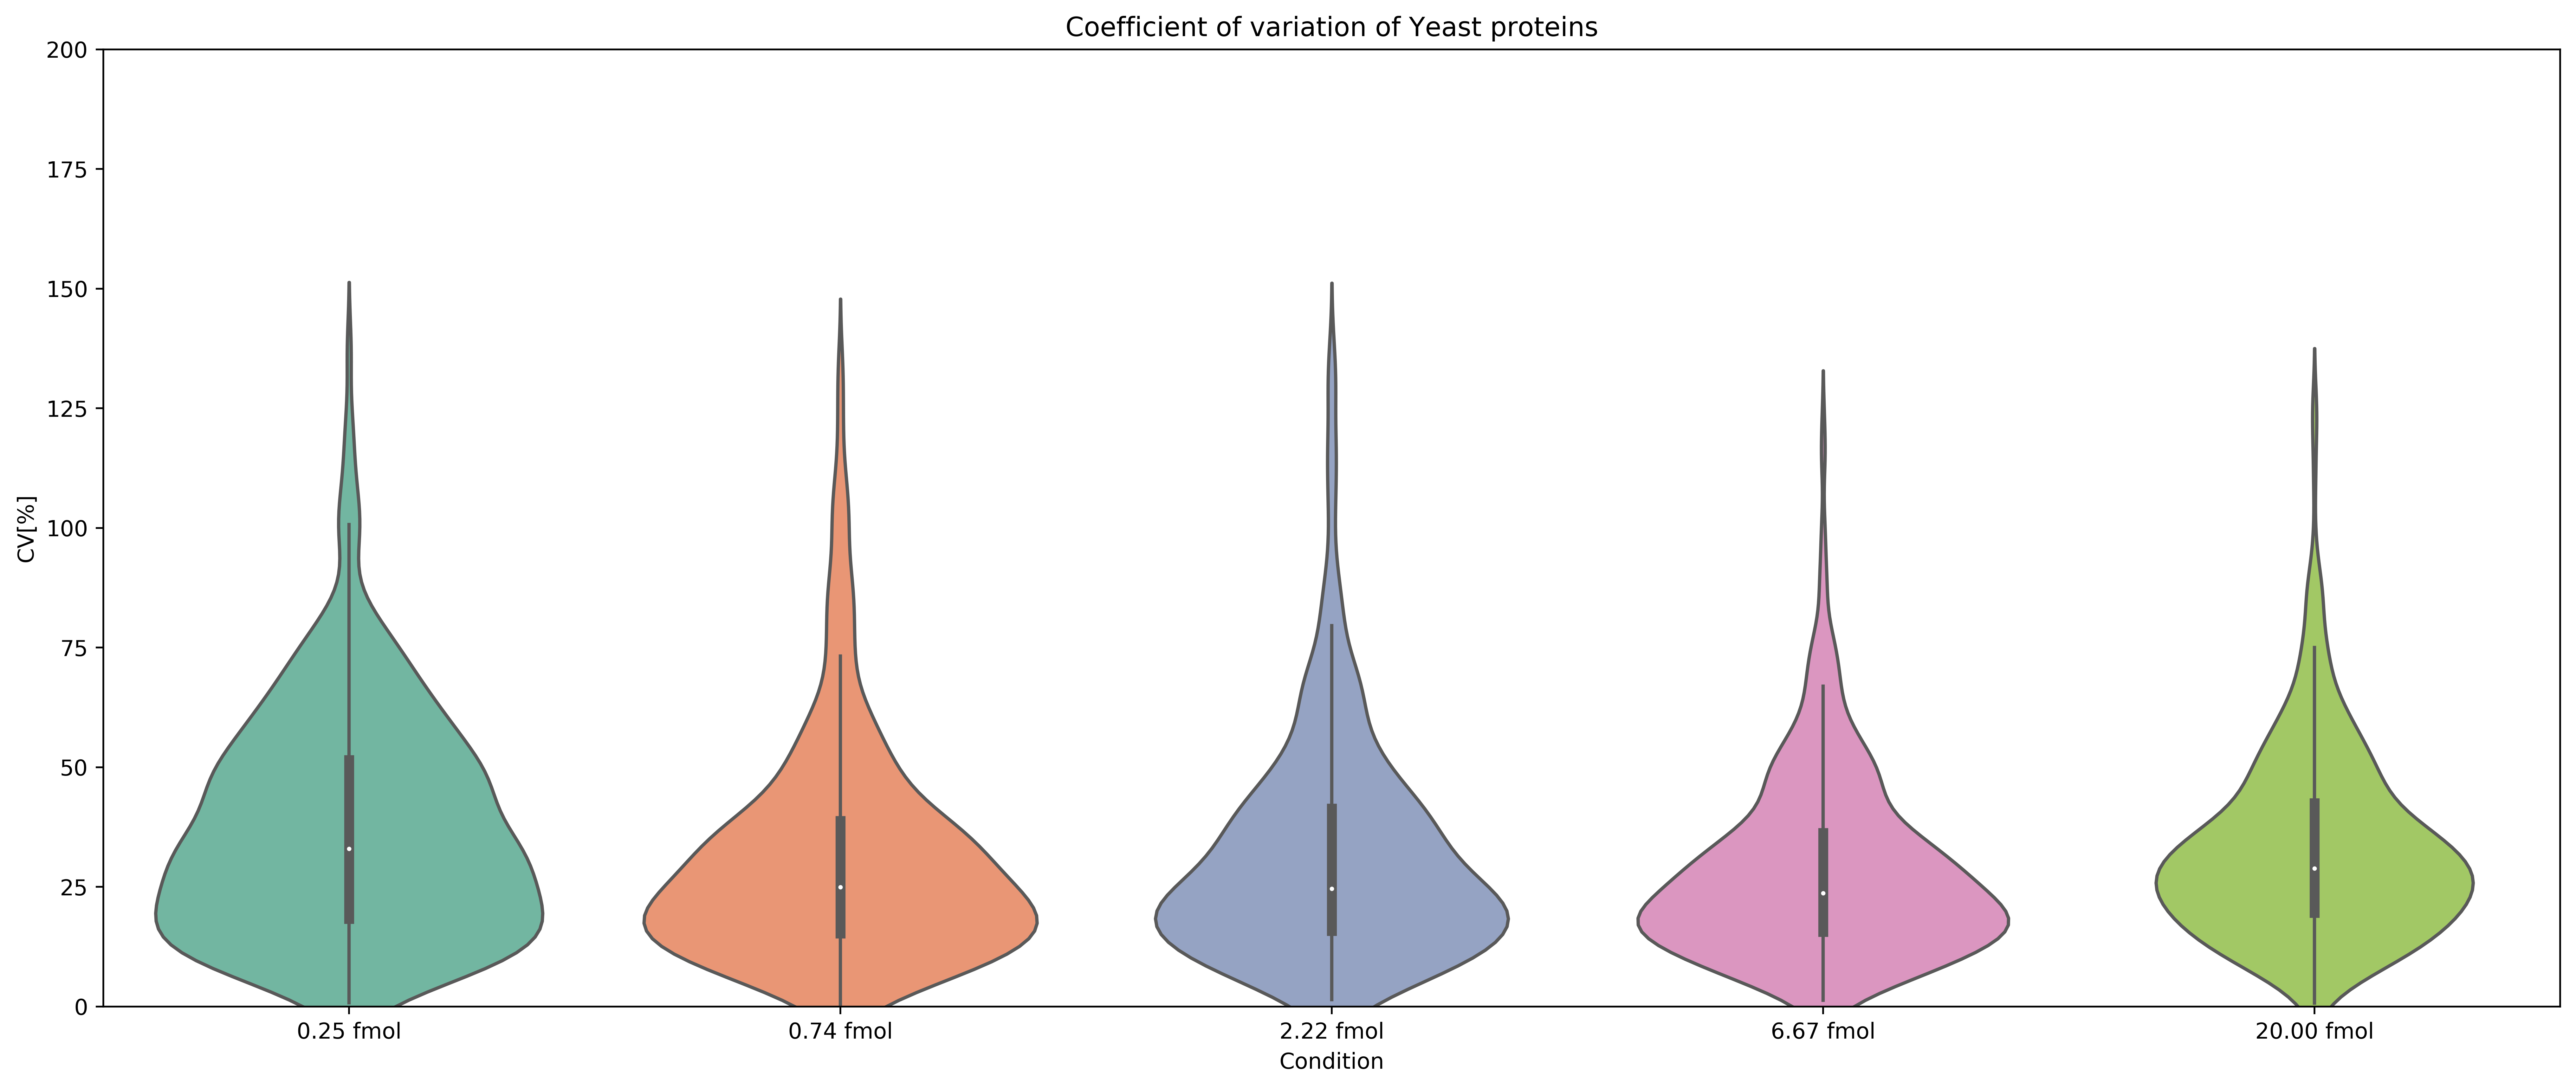

In [27]:
b_data = pd.DataFrame(None,columns = ['ProteinName','TechRep1','TechRep2', 'TechRep3', 'Condition', "CV[%]"])
quantms_background = quantms[-quantms['ProteinName'].str.contains("UPS")]
for condition in np.unique(quantms_background['Condition']):
    quantms_background_condition = quantms_background.loc[quantms_background['Condition'] == condition]
    cvs = []
    for protein in np.unique(quantms_background_condition['ProteinName']):
        msruns = np.unique(quantms_background_condition[quantms_background_condition['ProteinName'] == protein]['Run'])
        
        # proteins were filtered out if not quantified in all replicates
        if len(msruns) < 3:
            continue
            
        tech_intensity = []
        # summarized protein intensity in a technical replicate
        for run in msruns:
            t = quantms_background_condition[(quantms_background_condition['ProteinName'] == protein) & ((quantms_background_condition['Run'] == run))]
            
            pep_intensity = []
            for pep in np.unique(t['PeptideSequence']):
                pep_intensity.append(np.sum(t[t['PeptideSequence'] == pep]['Intensity']))
            tech_intensity.append(np.median(pep_intensity))
            
        mean = np.mean(tech_intensity)
        std = np.std(tech_intensity)
        cvs.append(100 * (std / mean))
        b_data = b_data.append({'ProteinName':protein,'TechRep1':tech_intensity[0], 
                       'TechRep2': tech_intensity[1], 'TechRep3': tech_intensity[2], 
                       'Condition': condition.replace("CT=Mixture;CN=UPS1;QY=",""), "CV[%]": 100 * (std / mean)}, ignore_index=True)
    print(condition + " mean cv: %f" %(np.mean(cvs)))
    
plt.figure(figsize=(20,8), dpi=500)
plt.ylim(0, 200)
plt.title("Coefficient of variation of Yeast proteins")
sns.violinplot(x = "Condition", y="CV[%]", data=b_data, scale= "count", palette="Set2", 
               order=['0.25 fmol', '0.74 fmol', '2.22 fmol', '6.67 fmol', '20.00 fmol'])

plt.show()

### QCplots and Calculate FC

In [17]:
%%R -w 800 -h 600

library('MSstats', warn.conflicts = F, quietly = T, verbose = F)
library("dplyr")


protein_expression = 'protein_expression.csv'

raw.om <- read.csv('out_msstats.csv', header = TRUE, sep = ',')
raw.om <- raw.om[!grepl("DECOY", raw.om$ProteinName),]

raw.om$Condition <- sub("CT=Mixture;CN=UPS1;QY=", "", raw.om$Condition)

# If run dataProcess() occuring an error message, please change "summaryMethod = 'TMP'" to "summaryMethod = 'linear'"
quantms.proposed <- MSstats::dataProcess(raw = raw.om,
                                           normalization = 'equalizeMedians',
                                           summaryMethod = 'TMP',
                                           censoredInt = "NA",
                                           MBimpute = TRUE)

# Write the expression protein log values into the expression csv 
head(quantms.proposed$ProteinLevelData)
Protein.Expression <- quantms.proposed$ProteinLevelData[, c('Protein', 'LogIntensities', 'GROUP')]
head(Protein.Expression)
write.csv(Protein.Expression, file=protein_expression, row.names=FALSE)

INFO  [2021-12-09 19:57:04] ** Features with one or two measurements across runs are removed.
INFO  [2021-12-09 19:57:04] ** Fractionation handled.
INFO  [2021-12-09 19:57:04] ** Updated quantification data to make balanced design. Missing values are marked by NA
INFO  [2021-12-09 19:57:04] ** Log2 intensities under cutoff = 12.803  were considered as censored missing values.
INFO  [2021-12-09 19:57:04] ** Log2 intensities = NA were considered as censored missing values.
INFO  [2021-12-09 19:57:04] ** Use all features that the dataset originally has.
INFO  [2021-12-09 19:57:05] 
 # proteins: 1208
 # peptides per protein: 1-60
 # features per peptide: 1-1
INFO  [2021-12-09 19:57:05] Some proteins have only one feature: 
 P00167ups|CYB5_HUMAN_UPS,
 P01112ups|RASH_HUMAN_UPS,
 P15559ups|NQO1_HUMAN_UPS,
 P16083ups|NQO2_HUMAN_UPS,
 P62988ups|UBIQ_HUMAN_UPS ...
INFO  [2021-12-09 19:57:05] 
                    0.25 fmol 0.74 fmol 2.22 fmol 20.00 fmol 6.67 fmol
             # runs         3    

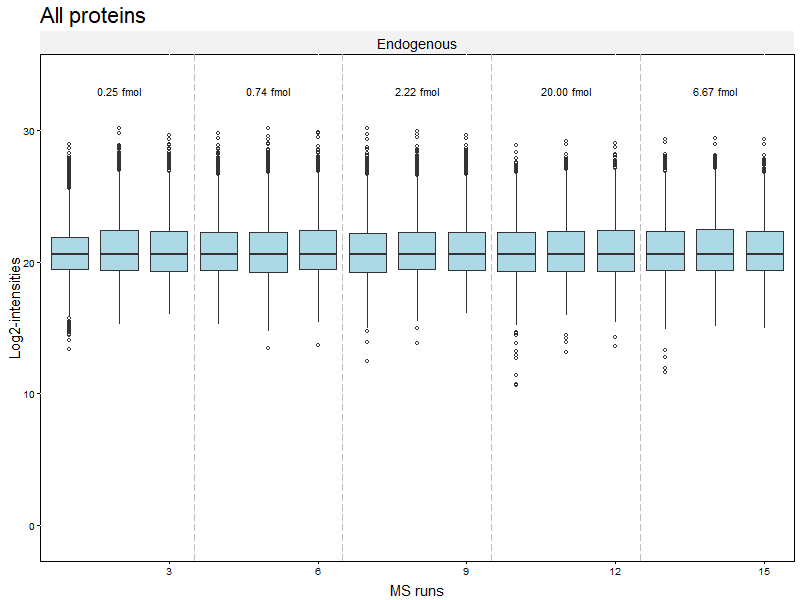

In [11]:
%%R -w 800 -h 600
tmp <- levels(quantms.proposed$ProcessedData$PROTEIN)
selector <- append('allonly', tmp, 1)
dataProcessPlots(data = quantms.proposed, type="QCPlot",which.Protein=selector,width=10, height=5, address=FALSE)

[1] "sp|P04821|CDC25_YEAST"
  |======                                                                |   8%


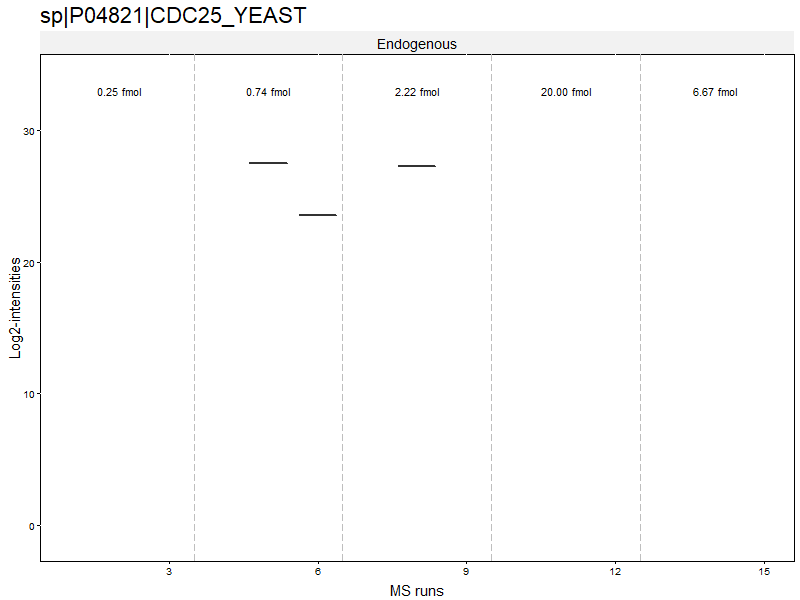

In [12]:
%%R -w 800 -h 600

Protein.Expression2 <- Protein.Expression[order(Protein.Expression$LogIntensities,decreasing = TRUE),]
protein_accession <- as.character(Protein.Expression2$Protein[1])
print(protein_accession)
tmp <- levels(quantms.proposed$ProcessedData$PROTEIN)
selector <- append(protein_accession, tmp, 1)
dataProcessPlots(data = quantms.proposed, type="QCPlot",which.Protein=selector,width=10, height=5, address=FALSE)

#### background proteins: Intensity shoud be identical in all MSrun

  |======================================================================| 100%
  |======================================================================| 100%


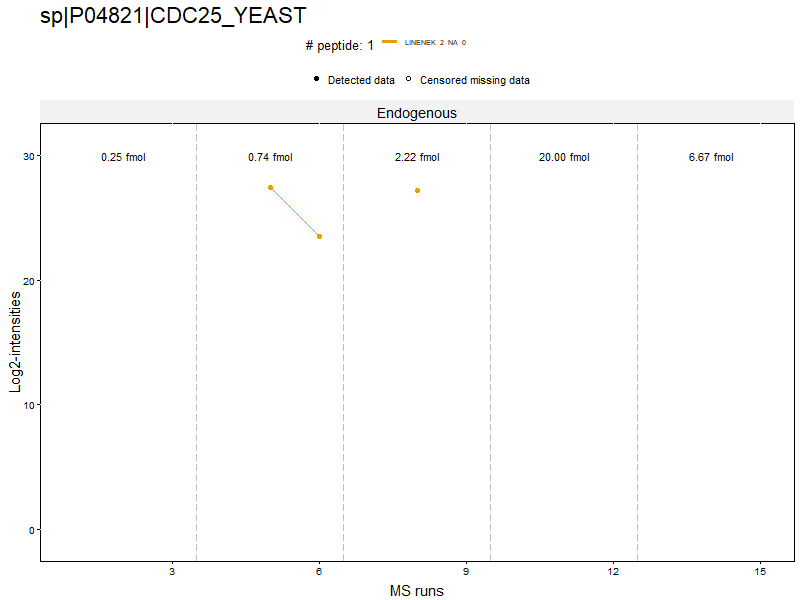

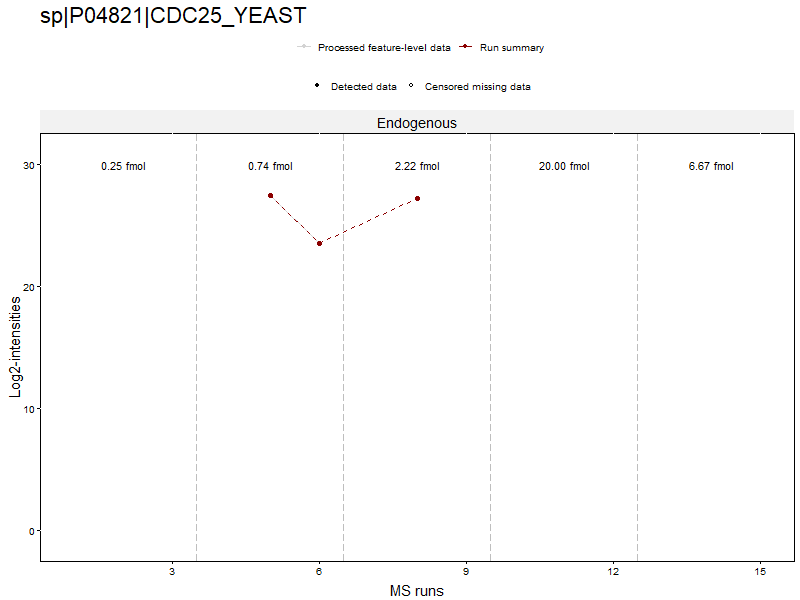

In [13]:
%%R -w 800 -h 600

tmp <- levels(quantms.proposed$ProcessedData$PROTEIN)
selector <- append(protein_accession, tmp, 1)
dataProcessPlots(data = quantms.proposed, type="ProfilePlot",which.Protein=selector,width=10, height=5, address=FALSE)

  |=                                                                     |   2%


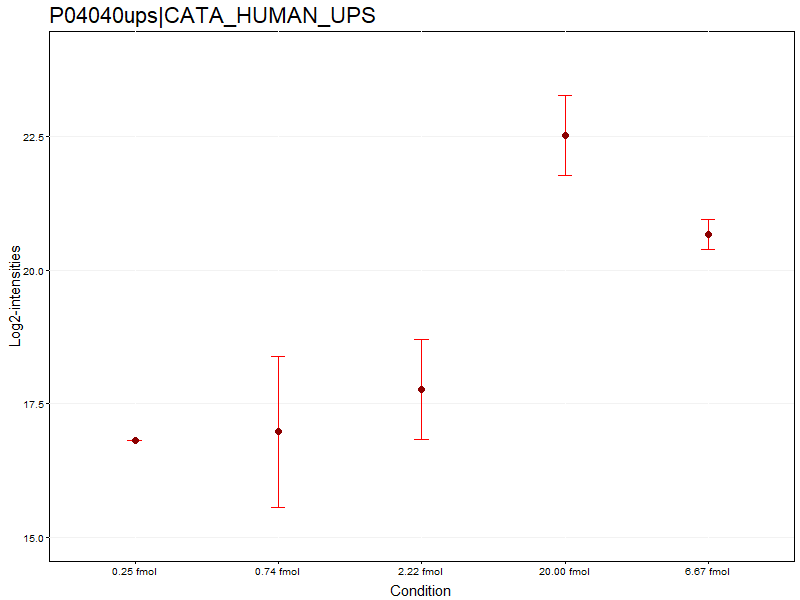

In [14]:
%%R -w 800 -h 600

tmp <- levels(quantms.proposed$ProcessedData$PROTEIN)
selector <- append("P04040ups|CATA_HUMAN_UPS", tmp, 1)
dataProcessPlots(data = quantms.proposed, type="ConditionPlot",which.Protein=selector,width=10, height=5, address=FALSE)

In [15]:
%%R

ac_groups = levels(quantms.proposed$FeatureLevelData$GROUP)
groups = levels(quantms.proposed$ProteinLevelData$GROUP)
print(groups)
comparison_matrix = c(0,0,0,-1,0,0,-1,0,-1,-1,0,0,-1,0,0,-1,0,-1,0,1,0,-1,0,0,-1,0,0,1,1,-1,1,1,1,1,0,0,0,0,0,0,-1,0,0,0,1,1,1,0,0,0)
comparison <- matrix(comparison_matrix, nrow=10)

colnames(comparison) <- groups[order(as.numeric(groups))]
row.names(comparison) <- c("20vs6.7", "20vs2.2", "20vs0.74","20vs0.25","6.7vs2.2", "6.7vs0.74", "6.7vs0.25","2.2vs0.74", 
                          "2.2vs0.25", "0.74vs0.25")
print(comparison)

[1] "0.25 fmol"  "0.74 fmol"  "2.22 fmol"  "20.00 fmol" "6.67 fmol" 
           0.25 fmol 0.74 fmol 2.22 fmol 20.00 fmol 6.67 fmol
20vs6.7            0         0         0          1        -1
20vs2.2            0         0        -1          1         0
20vs0.74           0        -1         0          1         0
20vs0.25          -1         0         0          1         0
6.7vs2.2           0         0        -1          0         1
6.7vs0.74          0        -1         0          0         1
6.7vs0.25         -1         0         0          0         1
2.2vs0.74          0        -1         1          0         0
2.2vs0.25         -1         0         1          0         0
0.74vs0.25        -1         1        -1          0         0


In [16]:
%%R

ResultComparison <- groupComparison(contrast.matrix=comparison, data=quantms.proposed)
head(ResultComparison$ComparisonResult)
write.csv(ResultComparison$ComparisonResult, 'comparison_res.csv', row.names=FALSE,col.names=TRUE,sep=",")

INFO  [2021-12-09 19:55:03]  == Start to test and get inference in whole plot ...
  |======================================================================| 100%
INFO  [2021-12-09 19:55:15]  == Comparisons for all proteins are done.


### Measure Accuracy of protein quantification

#### Since the aim of most proteomcis studies is to analyze differential protein expression by revealing significant quantitative differences between complex proteomes, protein quantificaiton and ratio accurancy in pairwise comparisons are important factos to consider. Therefore calculated the log2FC olf protein intensities for each possible pair of the 5 UPS1 concentrations testded (a total of 10 pairwise comparisons)

#### Computing the error between the experimental FC and expected FC. There are two metrcis including MAPE and MSE. The former is a relative error. The latter is a absolute error.

#### MAPE (Mean absolute percentage error) of detected UPS1 protein concentrations relative to the corresponding know concentrations for 36 paired comparisions. MAPE(%) = 1/N * (expected log2FC - experimental log2FC / expected log2FC) * 100. N=number of UPS1 quantified proteins

In [18]:
compar_res = pd.read_csv("comparison_res.csv", sep=',', header=0)
compar_res.head()

,Protein,Label,log2FC,SE,Tvalue,DF,pvalue,adj.pvalue,issue,MissingPercentage,ImputationPercentage
0,O00762ups|UBE2C_HUMAN_UPS,20vs6.7,1.431368,0.270520,5.291173,6.0,0.001845,0.063015,NaN,0.238095,0.238095
1,O00762ups|UBE2C_HUMAN_UPS,20vs2.2,3.067992,0.302451,10.143778,6.0,0.000053,0.002130,NaN,0.523810,0.357143
2,O00762ups|UBE2C_HUMAN_UPS,20vs0.74,4.653759,0.302451,15.386840,6.0,0.000005,0.000308,NaN,0.571429,0.404762
3,O00762ups|UBE2C_HUMAN_UPS,20vs0.25,5.373789,0.382573,14.046437,6.0,0.000008,0.000584,NaN,0.595238,0.261905
4,O00762ups|UBE2C_HUMAN_UPS,6.7vs2.2,1.636623,0.302451,5.411209,6.0,0.001646,0.023531,NaN,0.523810,0.357143


#### Except for comparison of lower concentration (0.74vs0.25), MAPE are all around 25%. For the comparison of lowest concentrations, the MAPE is 196.90%. Such discrepancies in the errors might be due to the inability to distinguish between signal and noise(background) at lowest analyte concentrations. This situation is also consistent with the previous analysis. Because many UPS1 proteins are not quantified in lowest concentrations

[24.964054359035735, 22.93274158961547, 18.210889672376997, 15.93255254282911, 40.8312578425812, 25.546275576088142, 23.53927568035004, 29.559857615276968, 35.20770486368407, 196.89647319914755]


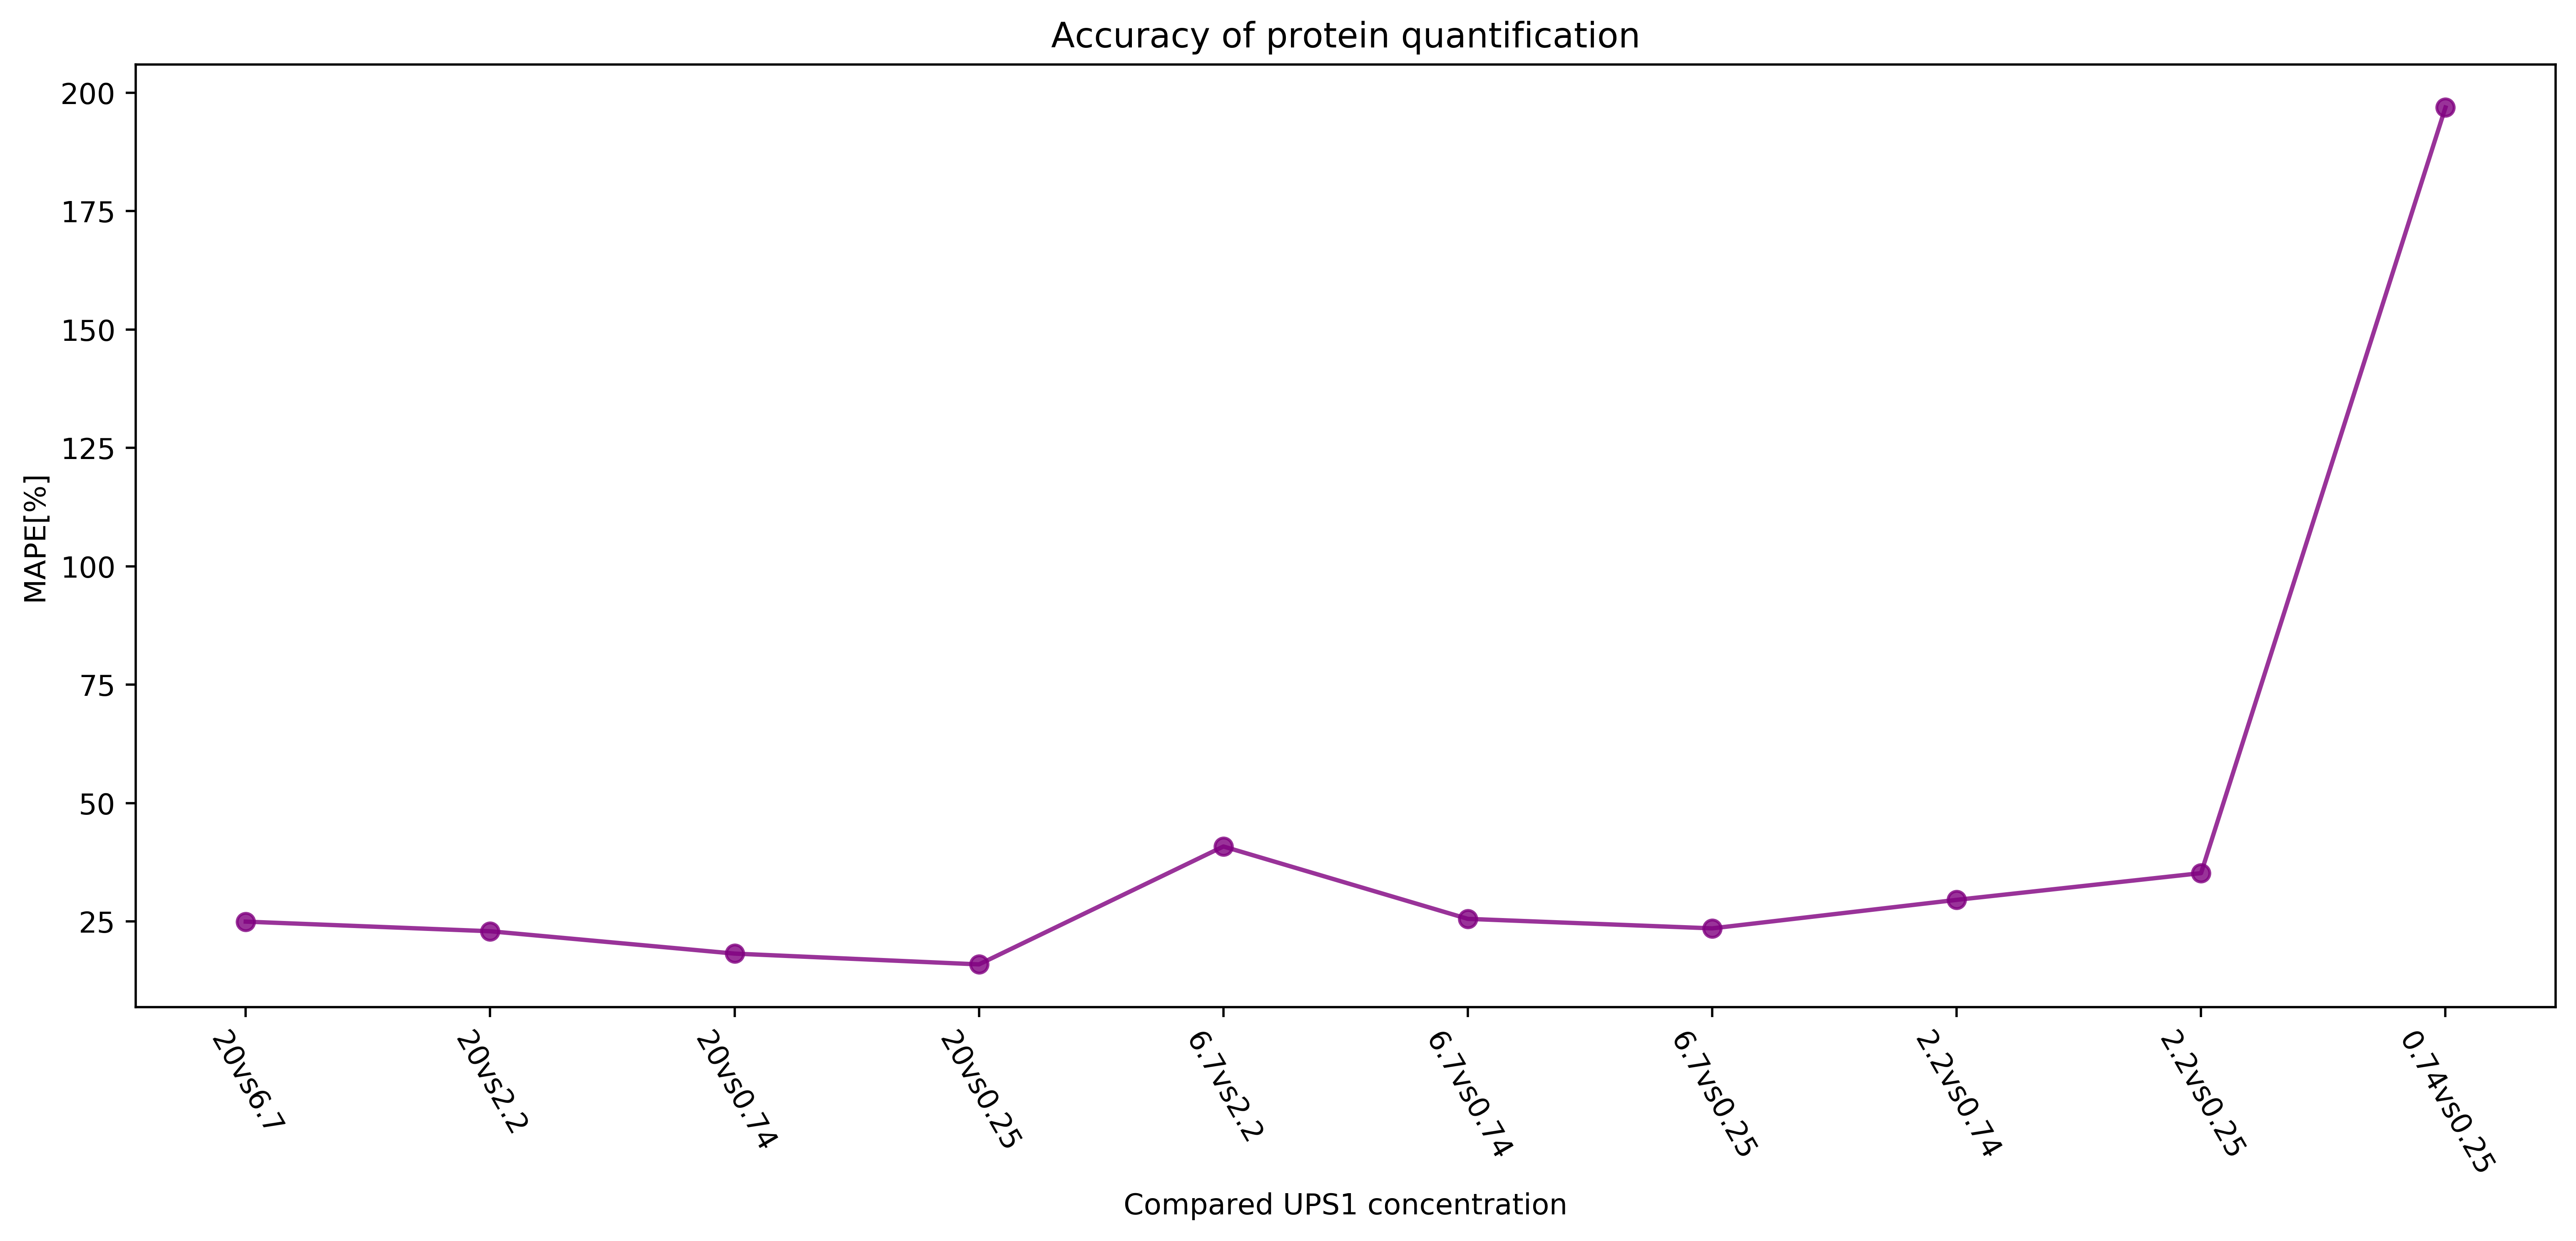

In [21]:
# calculate MAPE
import math

MAPE = []
ups_comp = compar_res[compar_res['Protein'].str.contains("UPS")]
conditions = ["20vs6.7", "20vs2.2", "20vs0.74","20vs0.25","6.7vs2.2", "6.7vs0.74", "6.7vs0.25","2.2vs0.74", 
                          "2.2vs0.25", "0.74vs0.25"]
for condition in conditions:
    t = ups_comp[ups_comp['Label'] == condition]
    ape = []
    for protein in t['Protein']:
        if "Missing" in str(t[t['Protein'] == protein]['issue'].values[0]):
            continue
        experimental_log2FC = t[t['Protein'] == protein]['log2FC']
        expected_log2FC = np.log2(float(condition.split("vs")[0]) / float(condition.split("vs")[1]))
        ape.append(np.abs(expected_log2FC - experimental_log2FC) / expected_log2FC * 100)
    MAPE.append(np.mean(ape))

print(MAPE)
plt.figure(figsize=(15,6), dpi=500)
plt.plot(range(10), MAPE, 'ro-', color='purple', alpha=0.8, label='')
plt.xticks(range(10), conditions)
plt.title("Accuracy of protein quantification")
plt.xlabel("Compared UPS1 concentration")
plt.ylabel("MAPE[%]")
plt.xticks(rotation=300)
plt.show()

#### The MSE (expected logFC - experimental logFC)^2 of the logFC estimates in the all two-group comparisons. For the spiked-in proteins, quantms has very low mean MSE (1.59) compared with other research (DOI: 10.1093/bib/bbx054). And mean MSE of background proteins is also low: 0.63. But existed Larger std, this implies that there are outliers

0.3258549817966505
0.17392813564301476
1.5942278523733082
0.6335011643212882
3.1318054039105756
1.810854134185355


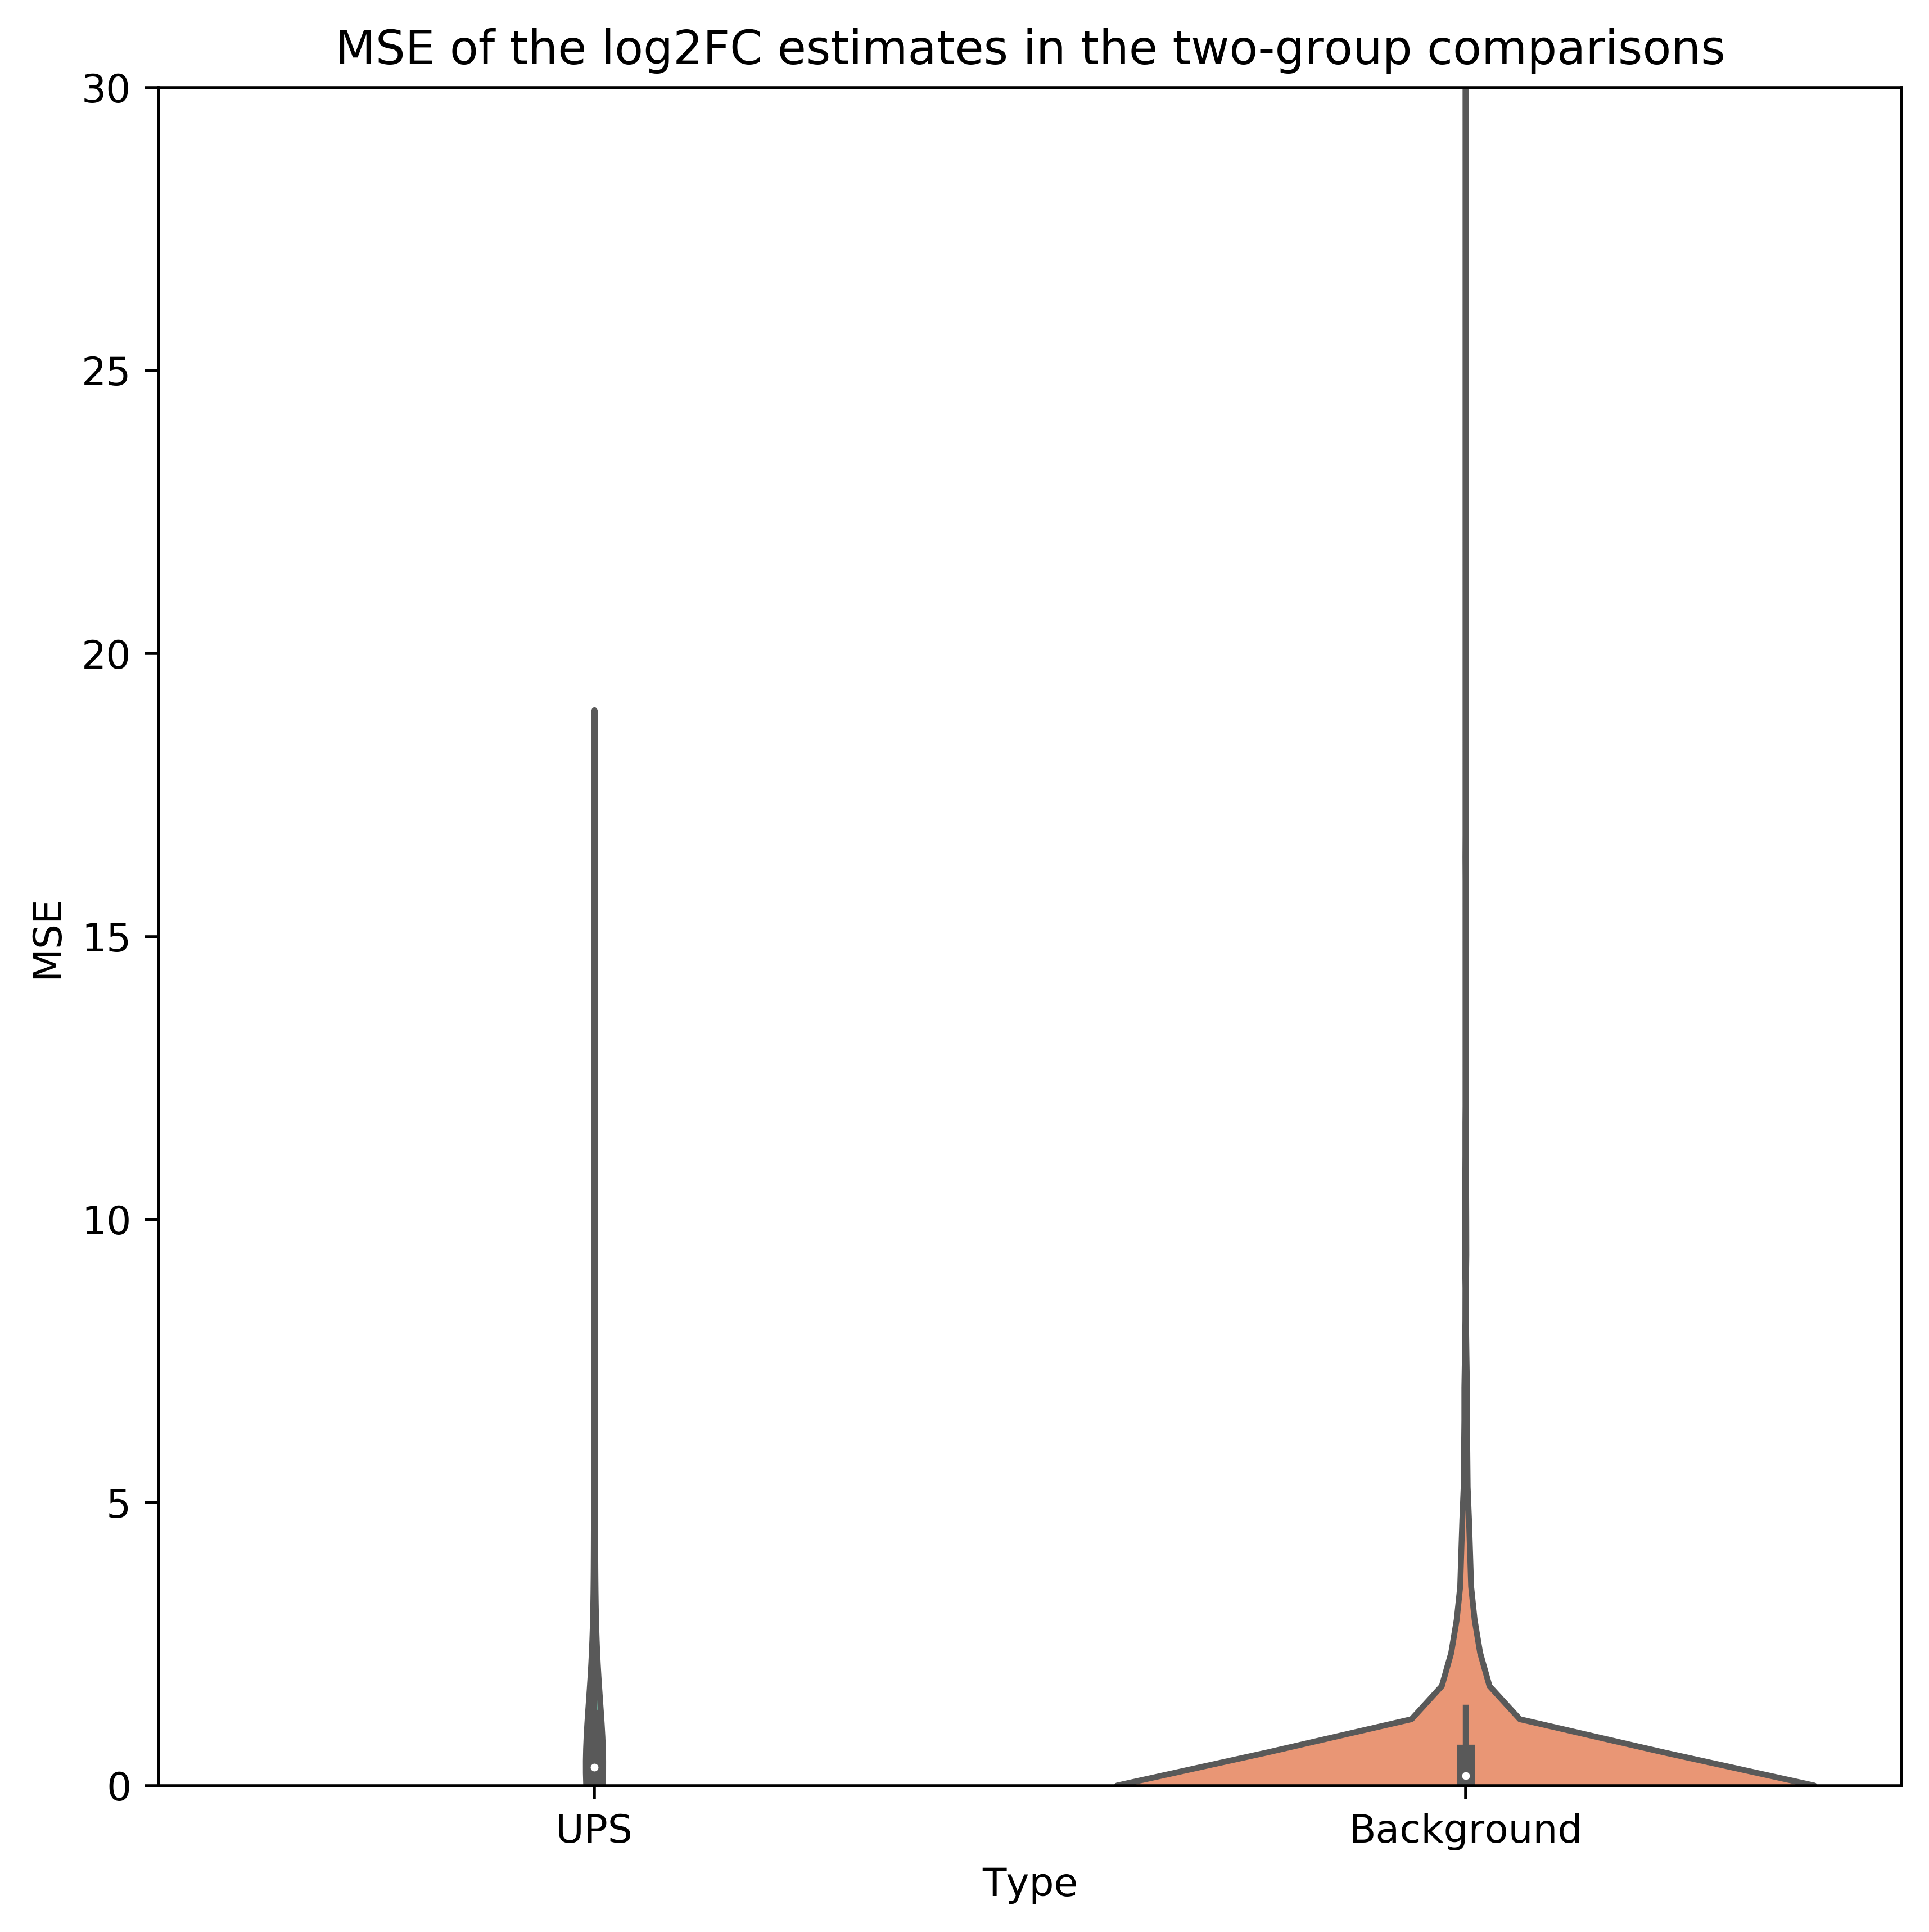

In [22]:
MSEs = pd.DataFrame(columns=["Type", "MSE"])
for _, row in compar_res.iterrows():
    if "Missing" in str(row['issue']):
        continue
    experimental_log2FC = row['log2FC']
    condition = row['Label']
    if "UPS" in row['Protein']:
        datatype = "UPS"
        expected_log2FC = np.log2(float(condition.split("vs")[0]) / float(condition.split("vs")[1]))
    else:
        expected_log2FC = 0
        datatype = "Background"
    mse = (experimental_log2FC - expected_log2FC) ** 2
    MSEs = MSEs.append({'Type': datatype, "MSE": mse}, ignore_index=True)

plt.figure(figsize=(8,8), dpi=500)
plt.ylim(0, 30)
plt.title("MSE of the log2FC estimates in the two-group comparisons")
sns.violinplot(x = "Type", y="MSE", data=MSEs, scale= "count", palette="Set2")
print(np.median(MSEs[MSEs['Type'] == "UPS"]['MSE']))
print(np.median(MSEs[MSEs['Type'] != "UPS"]['MSE']))
print(np.mean(MSEs[MSEs['Type'] == "UPS"]['MSE']))
print(np.mean(MSEs[MSEs['Type'] != "UPS"]['MSE']))
print(np.std(MSEs[MSEs['Type'] == "UPS"]['MSE']))
print(np.std(MSEs[MSEs['Type'] != "UPS"]['MSE']))
plt.show()

### Measure Sensitivity and specificity of the differential expression analysis

#### Proteins are typically chosen for follow-up experiment and validation based on the significance of their p-values or adj-pvalue/ q-value, especially for differential protein analysis. Thus, calculated the ROC curves based on adj-pvalue generated in the msstats.

#### Sensitivity (%) = 100 * TP / (TP+FN) and FDP (%) = 100 * FP / (FP+TP)；Specifity = TNR = TN / (TN + FN)

In [23]:
# filtered out missing value
compar_res = pd.read_csv("comparison_res.csv", sep=',', header=0)
compar_res = compar_res.query('(issue != issue) & (pvalue == pvalue)')
compar_res

,Protein,Label,log2FC,SE,Tvalue,DF,pvalue,adj.pvalue,issue,MissingPercentage,ImputationPercentage
0,O00762ups|UBE2C_HUMAN_UPS,20vs6.7,1.431368,0.270520,5.291173,6.0,0.001845,0.063015,NaN,0.238095,0.238095
1,O00762ups|UBE2C_HUMAN_UPS,20vs2.2,3.067992,0.302451,10.143778,6.0,0.000053,0.002130,NaN,0.523810,0.357143
2,O00762ups|UBE2C_HUMAN_UPS,20vs0.74,4.653759,0.302451,15.386840,6.0,0.000005,0.000308,NaN,0.571429,0.404762
3,O00762ups|UBE2C_HUMAN_UPS,20vs0.25,5.373789,0.382573,14.046437,6.0,0.000008,0.000584,NaN,0.595238,0.261905
4,O00762ups|UBE2C_HUMAN_UPS,6.7vs2.2,1.636623,0.302451,5.411209,6.0,0.001646,0.023531,NaN,0.523810,0.357143
...,...,...,...,...,...,...,...,...,...,...,...
12065,sp|Q99287|SEY1_YEAST,6.7vs0.74,-0.030910,0.437223,-0.070696,3.0,0.948089,0.971420,NaN,0.666667,0.333333
12067,sp|Q99287|SEY1_YEAST,2.2vs0.74,-0.074239,0.437223,-0.169797,3.0,0.875974,0.984723,NaN,0.666667,0.333333
12077,sp|Q99383|HRP1_YEAST,2.2vs0.74,-0.404748,0.162166,-2.495885,2.0,0.129960,0.923614,NaN,0.333333,0.000000
12078,sp|Q99383|HRP1_YEAST,2.2vs0.25,-0.267645,0.198612,-1.347573,2.0,0.310156,0.884237,NaN,0.500000,0.000000


#### ROC Curve in all comparisons

#### AUC is 0.86. It's better than other tools. see details in DOI: 10.1093/bib/bbx054

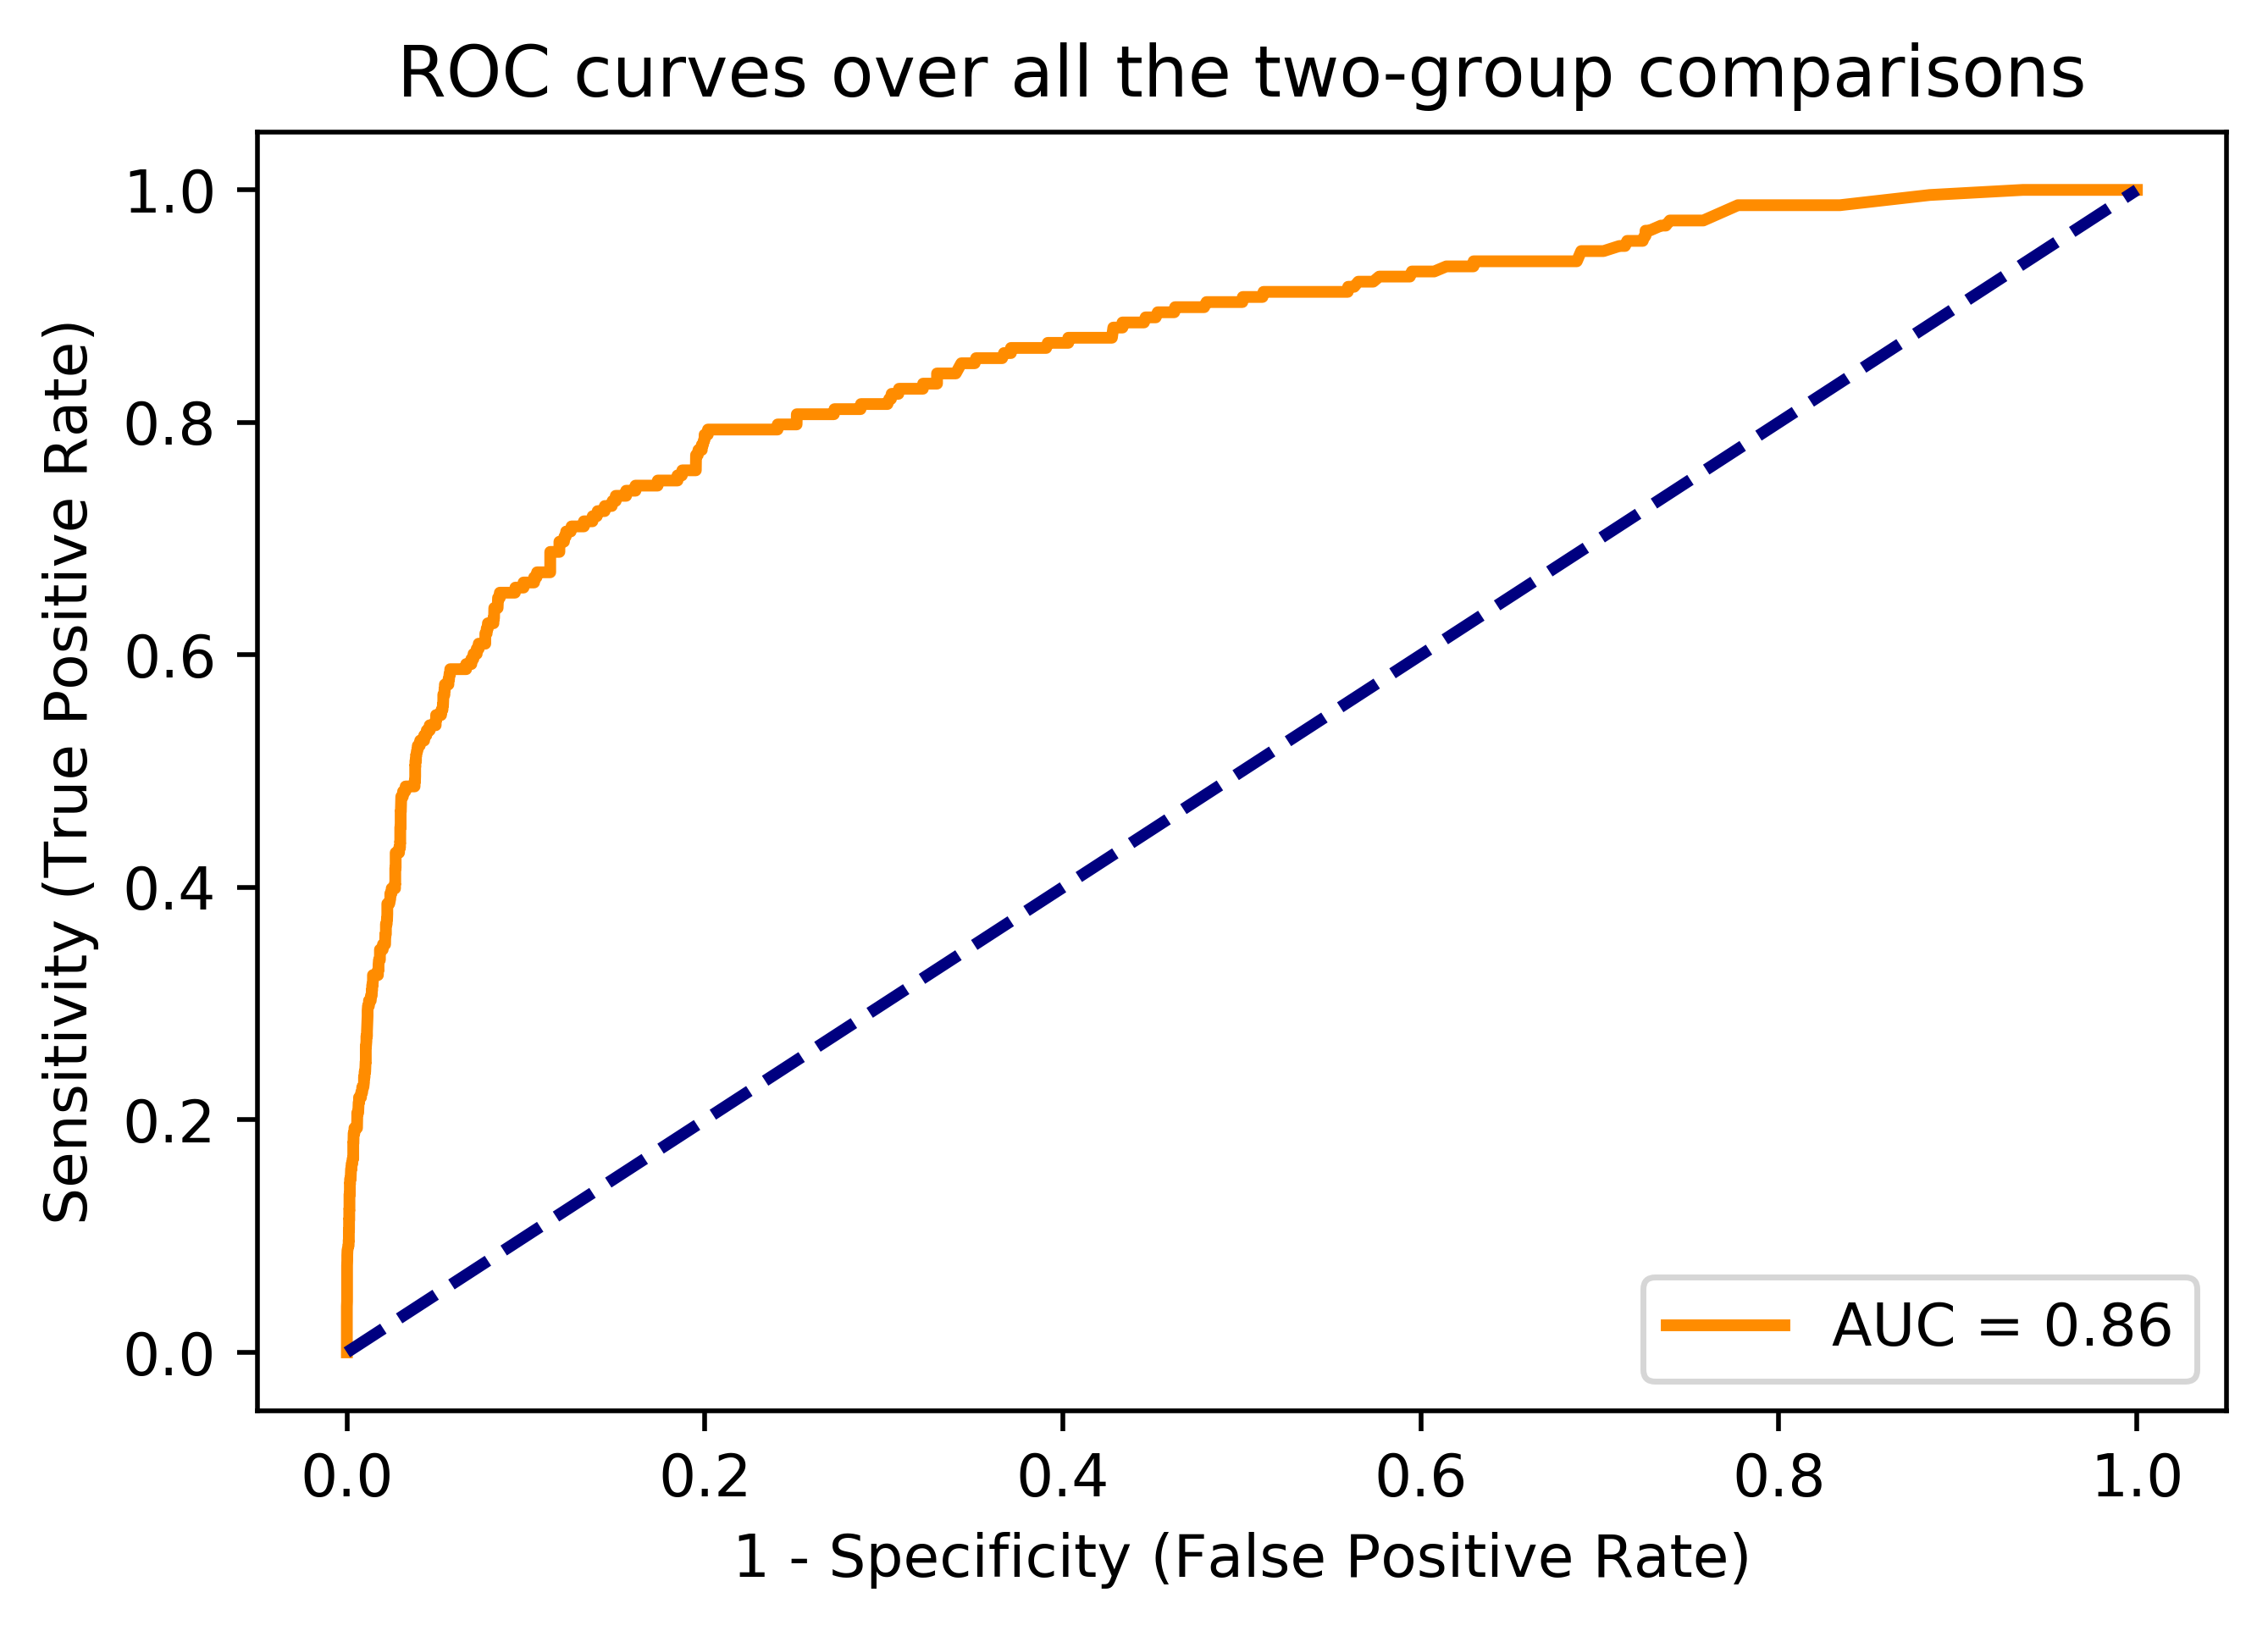

In [24]:
from sklearn import metrics

compar_res['value'] = 1 - compar_res['adj.pvalue']
compar_res['y'] = compar_res['Protein'].map(lambda x: ("UPS" in x and 1) or ("UPS" not in x and 0))

compar_res = compar_res.sort_values(by="value", ascending=False)
compar_res.head()

fpr, tpr, thresholds = metrics.roc_curve(compar_res['y'].tolist(), compar_res['value'].tolist(), pos_label = 1)
auc = metrics.auc(fpr, tpr)

plt.figure(dpi=500)

plt.plot(fpr, tpr, color="darkorange", lw=2, label="AUC = %0.2f" % auc)
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.title("ROC curves over all the two-group comparisons")
plt.xlabel("1 - Specificity (False Positive Rate)")
plt.ylabel("Sensitivity (True Positive Rate)")
plt.legend(loc="lower right")

# for _, row in compar_res.iterrows():
#     TP = len(compar_res[(compar_res['value'] >= row['value']) & (compar_res['Protein'].str.contains("UPS"))])
#     FN = len(compar_res[(compar_res['value'] < row['value']) & (compar_res['Protein'].str.contains("UPS"))])
#     TPR = TP /

#### pAUC within each comparison

#### Calculating the total AUC seems arbitrary, because pvalue distribution may be difference between comparisons. And the differential expression proteins were detected in difference comparisons. Thus, pAUC metric is calculated

#### Our results are better and more stable

Text(0.5, 1.0, 'pAUCs of each two-group comparison')

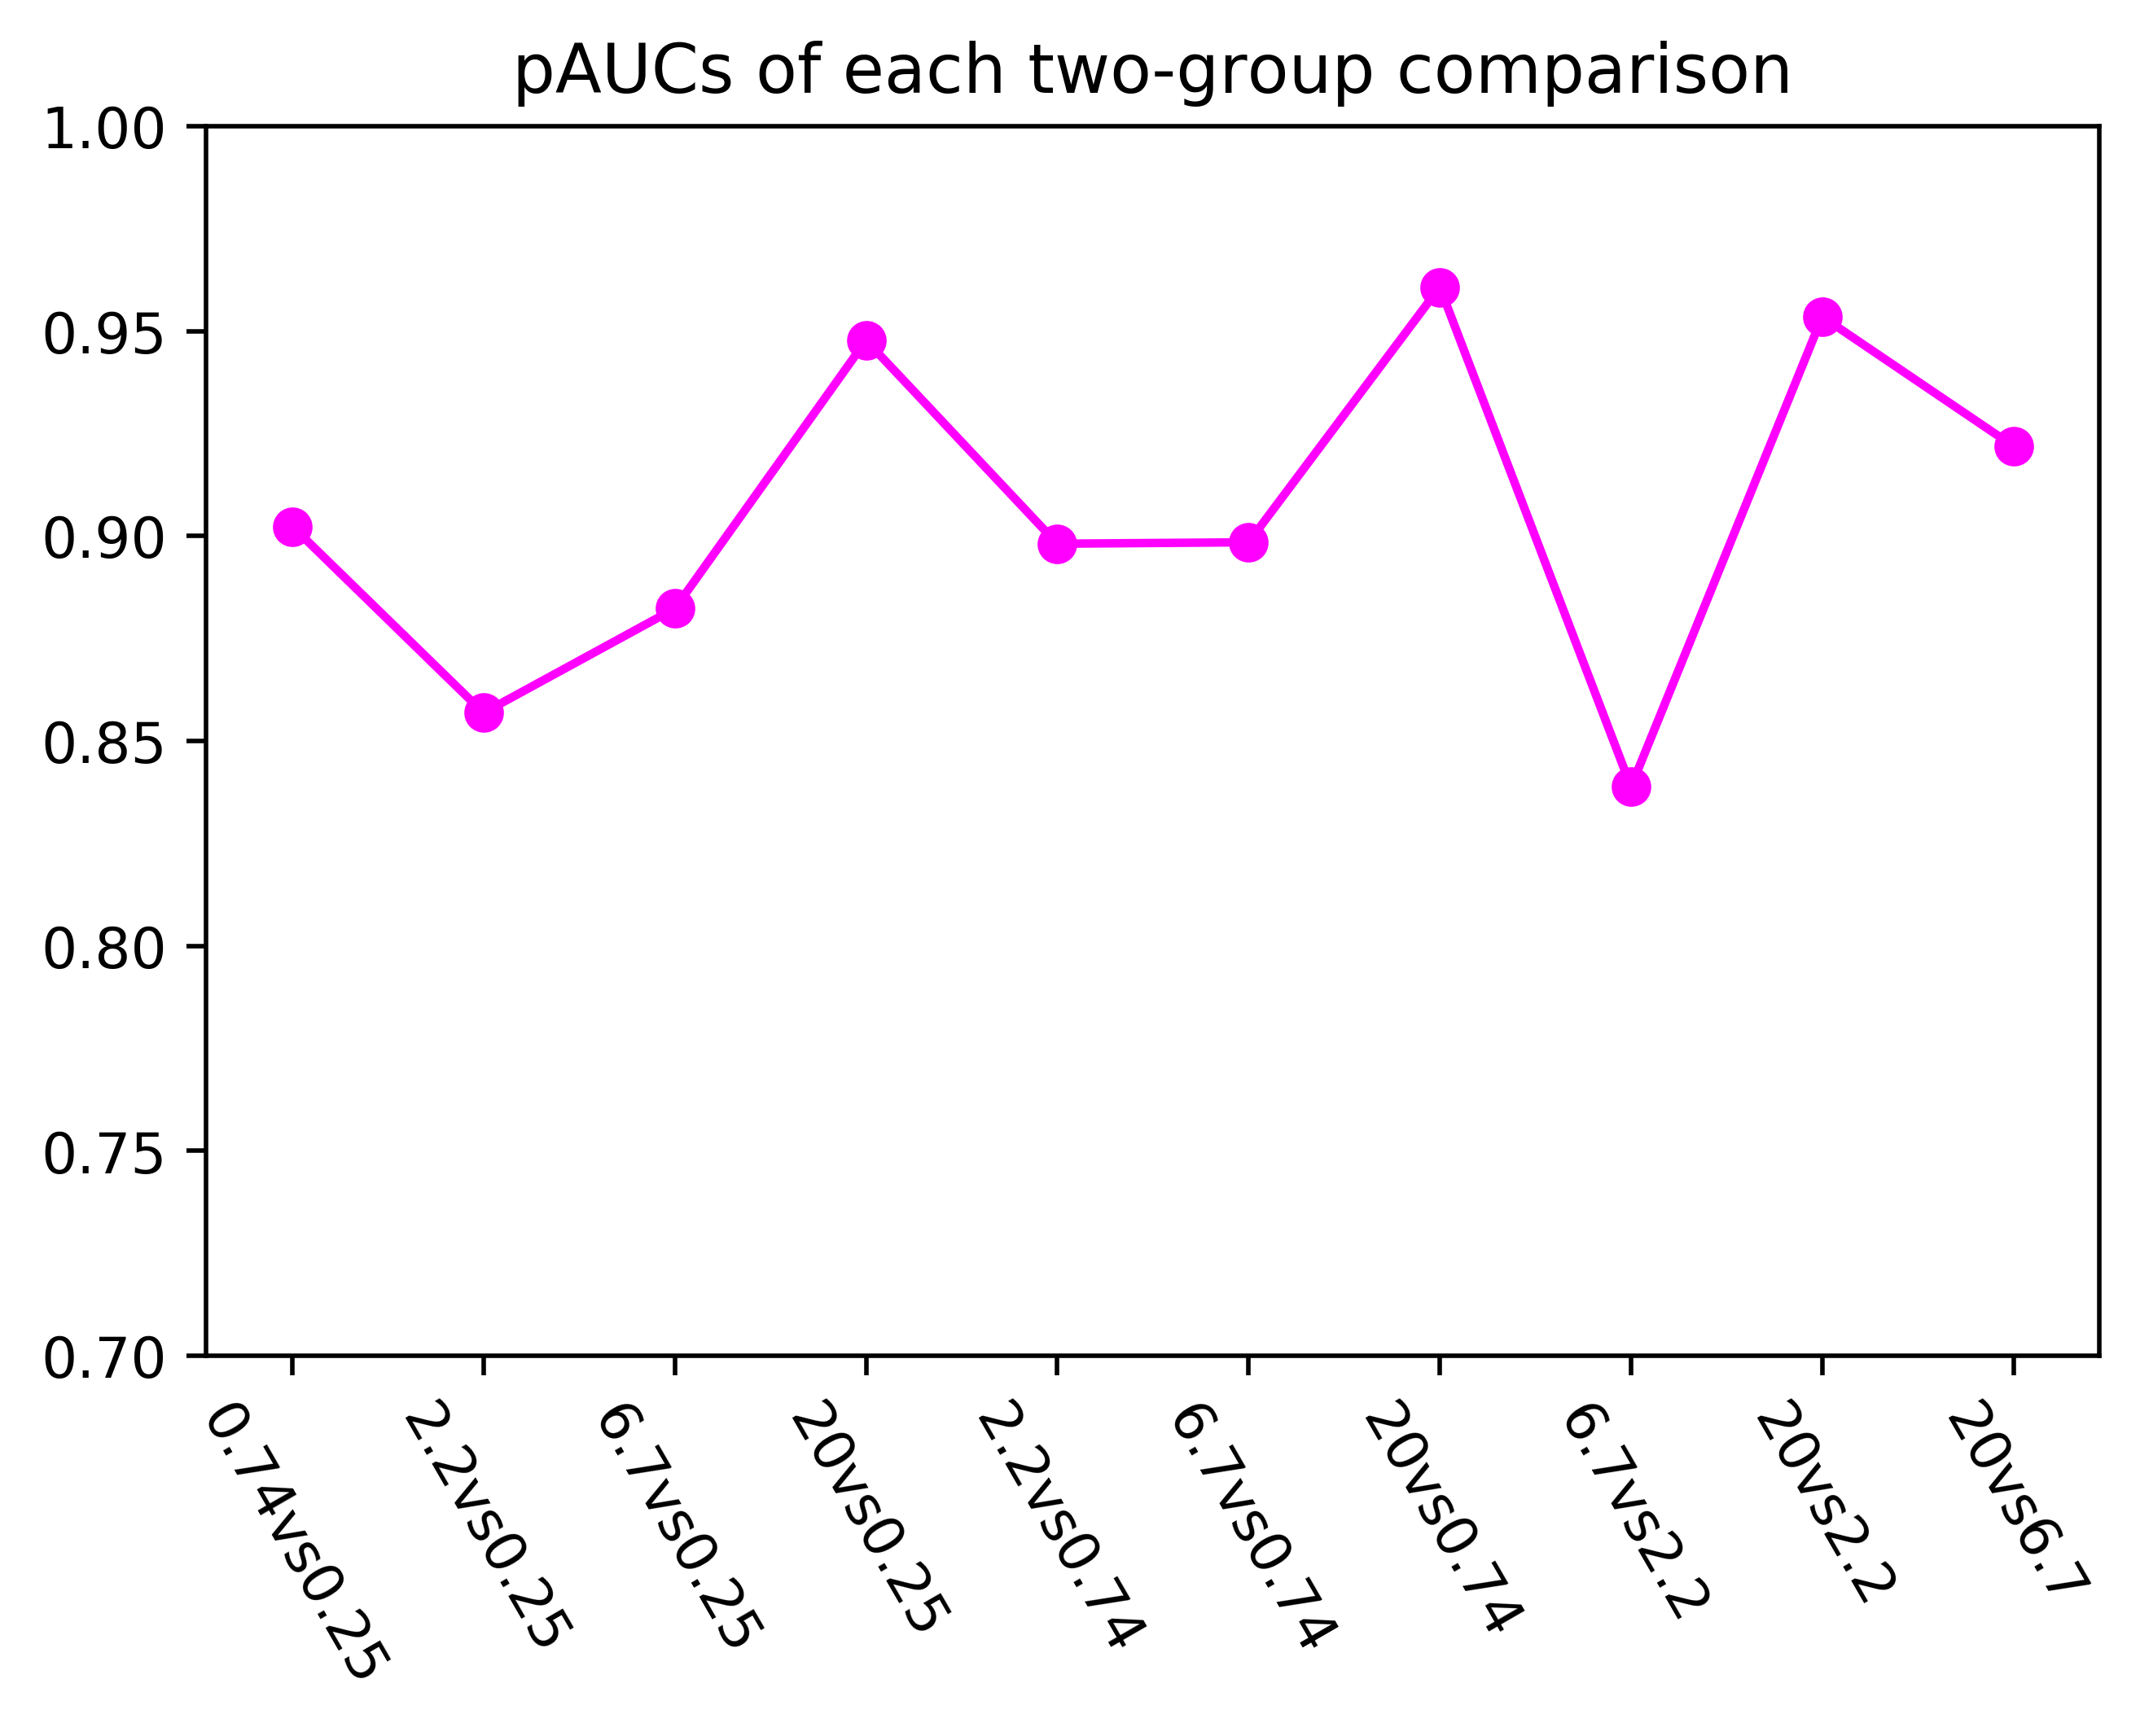

In [25]:
compar_res.head()

conditions = ["0.74vs0.25", "2.2vs0.25", "6.7vs0.25", "20vs0.25", "2.2vs0.74", "6.7vs0.74", "20vs0.74", "6.7vs2.2", "20vs2.2", "20vs6.7"]
paucs = []
for condition in conditions:
    comp_condition = compar_res[compar_res['Label'] == condition]
    fpr, tpr, thresholds = metrics.roc_curve(comp_condition['y'].tolist(), comp_condition['value'].tolist(), pos_label = 1)
    pauc = metrics.auc(fpr, tpr)
    paucs.append(pauc)

plt.figure(dpi=500)
plt.plot(range(10), paucs, 'ro-', color='magenta')
plt.xticks(range(10), conditions)
plt.ylim(0.7, 1)
plt.xticks(rotation=300)

plt.title("pAUCs of each two-group comparison")

#### Ignore the following analysis for now

In [31]:
from sklearn import metrics
# calculate z-score: (FC-FC average) / FC std
FC_Average = np.mean(compar_res['log2FC'])
FC_Std = np.std(compar_res['log2FC'])

compar_res['Z-Score'] = compar_res.apply(lambda x: (x['log2FC'] - FC_Average) / FC_Std, axis=1)

conditions = ["20vs6.7", "20vs2.2", "20vs0.74","20vs0.25","6.7vs2.2", "6.7vs0.74", "6.7vs0.25","2.2vs0.74", 
                          "2.2vs0.25", "0.74vs0.25"]

data = pd.DataFrame(columns=['value', 'metrics', 'label', 'value2'])
for condition in conditions:
    group = compar_res[compar_res['Label'] == condition]
    differential_proteins = group[(group['adj.pvalue'] < 0.05) & (np.abs(group['Z-Score']) > 1.96)]
    FN = len(group[((group['adj.pvalue'] >= 0.05) | (np.abs(group['Z-Score']) <= 1.96 )) & (group['Protein'].str.contains("UPS"))])
    TP = len(differential_proteins[differential_proteins['Protein'].str.contains("UPS")]['Protein'])
    FP = len(differential_proteins[-differential_proteins['Protein'].str.contains("UPS")]['Protein'])
    
    if TP + FP == 0:
        data = data.append({"value": 0, "metrics": "Sensitivity", "Label": condition, 'value2': 0}, ignore_index=True)
        data = data.append({"value": 0, "metrics": "FDP", "Label": condition, 'value2': 0}, ignore_index=True)
        continue
    Sensitivity = TP / (TP+FN) * 100
    FDP = FP / (FP + TP) * 100
    data = data.append({"value": Sensitivity, "metrics": "Sensitivity", "Label": condition, 'value2': Sensitivity}, ignore_index=True)
    data = data.append({"value": FDP, "metrics": "FDP", "Label": condition, 'value2': -FDP},ignore_index=True)
    
data.to_csv("./test1.csv", sep=',', index=False)

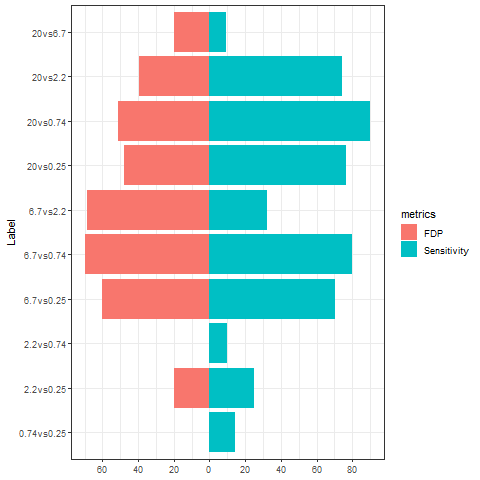

In [32]:
%%R 

library(ggplot2)
data = read.csv("test1.csv", sep=',',header = TRUE)
conditions = c("20vs6.7", "20vs2.2", "20vs0.74","20vs0.25","6.7vs2.2", "6.7vs0.74", "6.7vs0.25","2.2vs0.74", 
                          "2.2vs0.25", "0.74vs0.25")

conditions = rev(conditions)
data$Label <- factor(data$Label,levels=conditions)

ggplot(data = data) + geom_col(aes(x = Label, y = value2, fill = metrics)) + 
   scale_y_continuous(breaks = seq(from = -100, to = 100,by = 20),labels = c(seq(100, 0, -20), seq(20, 100, 20))) + 
   coord_flip() + theme_bw() + ylab(NULL)

# ggsave("sensitivity.png", dpi = 500)